# Methow Boxplots

In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
#from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
import hvplot.pandas
import pickle
from scipy import stats
from scipy.signal import savgol_filter
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [6]:
%matplotlib inline

In [7]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [10]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [11]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [12]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [13]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [14]:
mpl_epoch = '1970-01-01'

In [15]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load in the saved data:

In [16]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks/figure_production


In [17]:
#atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed.pkl', 'rb'))
atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic_7912.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))

snwd = pickle.load(open('../../data/snotel/snotel_snwd_35.pkl', 'rb'))
snwd_65 = pickle.load(open('../../data/snotel/snotel_snwd_65.pkl', 'rb'))
snotel_sites = pickle.load(open('../../data/snotel/snotel_sites_65.pkl', 'rb'))

snotel_geom = pickle.load(open('../../data/snotel/snotel_geometries.pkl', 'rb'))

cso_methow = pickle.load(open('../../../data/cso/cso-data.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:4: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:10: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  snotel_sites = pickle.load(open('../../data/snotel/snotel_sites_65.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_3274/130042338.py:12: UserWarning

In [18]:
atl06sr_gdf = atl06sr_gdf.rename(columns={'diff_plus_bicubic_update':'diff_plus_bicubic'})

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [19]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [20]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['snow_presence'] == 0)
    #(atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    
inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['snow_presence'] == 1)
    #(atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    

In [21]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

In [22]:
snwd.head()

,Muckamuck,Salmon Meadows,doy,decyear,dowy,acqdate
2018-10-03,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0,0.0,280,2018.764384,7,2018-10-07


In [22]:
atl06sr_gdf.shape

(148886, 33)

In [14]:
np.nanmedian(atl06sr_gdf['lidar_z'])

1062.7797

In [18]:
snotel_sites

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:699_WA_SNTL,699_WA_SNTL,Pope Ridge,SNOTEL,1094.232056,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (681575.109 5318154.881),1094.232056
SNOTEL:606_WA_SNTL,606_WA_SNTL,Lyman Lake,SNOTEL,1822.703979,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654799.692 5340403.427),1822.703979
SNOTEL:681_WA_SNTL,681_WA_SNTL,Park Creek Ridge,SNOTEL,1402.079956,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654147.806 5367847.622),1402.079956
SNOTEL:711_WA_SNTL,711_WA_SNTL,Rainy Pass,SNOTEL,1490.472046,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (667193.867 5376424.178),1490.472046
SNOTEL:817_WA_SNTL,817_WA_SNTL,Thunder Basin,SNOTEL,1316.735962,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (648435.062 5376887.468),1316.735962
SNOTEL:975_WA_SNTL,975_WA_SNTL,Swamp Creek,SNOTEL,1197.864014,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (663563.081 5382187.777),1197.864014
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959
SNOTEL:515_WA_SNTL,515_WA_SNTL,Harts Pass,SNOTEL,1978.151978,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (672206.062 5399027.491),1978.151978


In [17]:
atl06sr_gdf['lidar_z'].describe()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    146647.000000
mean       1147.133179
std         467.221466
min         411.855621
25%         745.645264
50%        1062.779663
75%        1547.768921
max        2495.339111
Name: lidar_z, dtype: float64

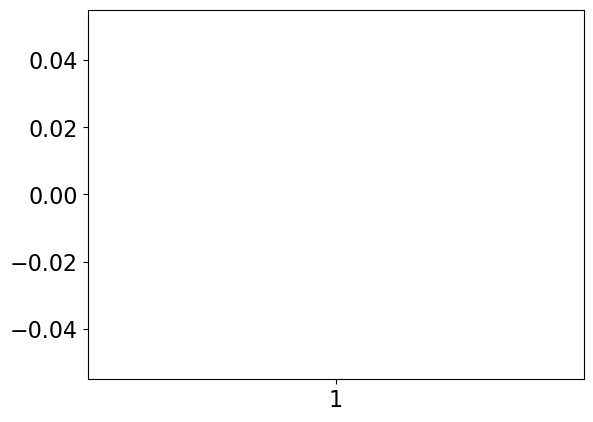

In [16]:
plt.boxplot(atl06sr_gdf['lidar_z'])
plt.show()

In [18]:
import myfunctions
from myfunctions import boxplot_date_aso_all

In [14]:
snow_columns = ['tum_m', 'dan_clean']

## Create Transparent Boxplots

Playing with parameters to see how each piece works:

In [179]:
bp_stats = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').apply(cbook.boxplot_stats)
bp_stats_list = [i[0] for i in bp_stats.values]
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = bp_alpha/bp_alpha.max()
pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values

In [187]:
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.25) + 0.25
#norm * (newRange[1] - newRange[0]) + newRange[0]

In [ ]:
(x-min(x))/(max(x)-min(x))

In [188]:
bp_alpha_boxes

array([0.34283965, 0.87270962, 0.28375412, 0.89924428, 0.85067128,
       0.26070252, 0.26025922, 0.395529  , 0.25234316, 0.34144642,
       0.2531031 , 0.73066368, 0.29432998, 0.58874441, 0.30914886,
       0.25050663, 0.54010808, 0.25006333, 0.77410707, 0.25766275,
       1.        , 0.31313856, 0.29027696, 0.74706578, 0.29072026,
       0.6708182 , 0.30794562, 0.73338681, 0.28033437, 0.25468631,
       0.7185046 , 0.25272313, 0.45062484, 0.27222832, 0.56081652,
       0.27197501, 0.34334628, 0.55986659, 0.35297222, 0.25031664,
       0.2999029 , 0.25      , 0.26158912, 0.27609136, 0.56841594,
       0.25500296, 0.4070548 , 0.25189986, 0.25025331, 0.2517732 ,
       0.25240648, 0.47392975, 0.26735202, 0.7608714 , 0.27235498,
       0.25126657])

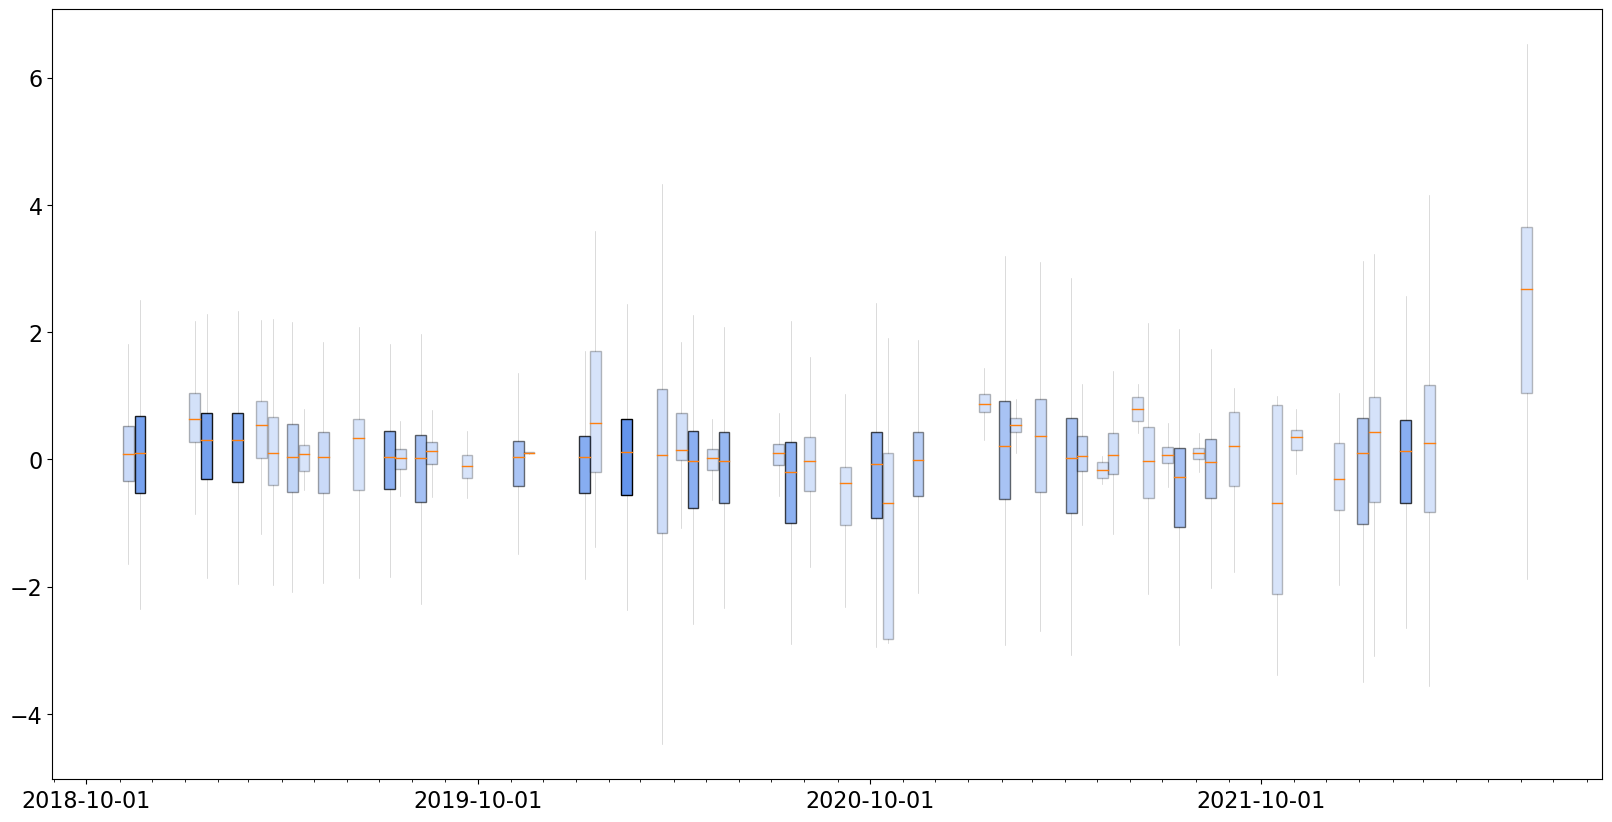

In [189]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'

f, ax = plt.subplots(figsize=(20,10))
bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, widths=10, patch_artist=True)

for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
    patch.set_alpha(alpha)
    patch.set_facecolor('cornflowerblue')

years = mdates.YearLocator(month=10)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
months = mdates.MonthLocator()
ax.xaxis.set_minor_locator(months)

### Transparent Boxplots with CDEC and ATL06SR Data

In [175]:
snwd

,Muckamuck,Salmon Meadows,doy,decyear,dowy,acqdate
2018-10-03,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0,0.0,280,2018.764384,7,2018-10-07
...,...,...,...,...,...,...
2022-10-14,0.0,0.0,287,2022.783562,14,2022-10-14
2022-10-15,0.0,0.0,288,2022.786301,15,2022-10-15
2022-10-16,0.0,0.0,289,2022.789041,16,2022-10-16
2022-10-17,0.0,0.0,290,2022.791781,17,2022-10-17


In [229]:
snwd_65

,Pope Ridge,Lyman Lake,Park Creek Ridge,Rainy Pass,Thunder Basin,Swamp Creek,Muckamuck,Salmon Meadows,Harts Pass,doy,decyear,dowy,acqdate
2018-10-03,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280,2018.764384,7,2018-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,291,2022.794521,18,2022-10-18
2022-10-19,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292,2022.797260,19,2022-10-19
2022-10-20,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293,2022.800000,20,2022-10-20
2022-10-21,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294,2022.802740,21,2022-10-21


In [259]:
snwd_65[snotel_sites[snotel_sites['elevation_m']<1000]['name']]

""
2018-10-03
2018-10-04
2018-10-05
2018-10-06
2018-10-07
...
2022-10-18
2022-10-19
2022-10-20
2022-10-21


In [241]:
len(snotel_sites)

10

In [250]:
snotel_sites

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:699_WA_SNTL,699_WA_SNTL,Pope Ridge,SNOTEL,1094.232056,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (681575.109 5318154.881),1094.232056
SNOTEL:606_WA_SNTL,606_WA_SNTL,Lyman Lake,SNOTEL,1822.703979,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654799.692 5340403.427),1822.703979
SNOTEL:681_WA_SNTL,681_WA_SNTL,Park Creek Ridge,SNOTEL,1402.079956,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654147.806 5367847.622),1402.079956
SNOTEL:711_WA_SNTL,711_WA_SNTL,Rainy Pass,SNOTEL,1490.472046,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (667193.867 5376424.178),1490.472046
SNOTEL:817_WA_SNTL,817_WA_SNTL,Thunder Basin,SNOTEL,1316.735962,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (648435.062 5376887.468),1316.735962
SNOTEL:975_WA_SNTL,975_WA_SNTL,Swamp Creek,SNOTEL,1197.864014,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (663563.081 5382187.777),1197.864014
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959
SNOTEL:515_WA_SNTL,515_WA_SNTL,Harts Pass,SNOTEL,1978.151978,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (672206.062 5399027.491),1978.151978


In [244]:
snwd_65.columns

Index(['Pope Ridge', 'Lyman Lake', 'Park Creek Ridge', 'Rainy Pass',
       'Thunder Basin', 'Swamp Creek', 'Muckamuck', 'Salmon Meadows',
       'Harts Pass', 'doy', 'decyear', 'dowy', 'acqdate'],
      dtype='object')

In [239]:
snotel_sites

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:699_WA_SNTL,699_WA_SNTL,Pope Ridge,SNOTEL,1094.232056,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (681575.109 5318154.881),1094.232056
SNOTEL:262_WA_SNTL,262_WA_SNTL,Mirror Lake,SNOTEL,1706.880005,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (674785.221 5335643.219),1706.880005
SNOTEL:606_WA_SNTL,606_WA_SNTL,Lyman Lake,SNOTEL,1822.703979,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654799.692 5340403.427),1822.703979
SNOTEL:681_WA_SNTL,681_WA_SNTL,Park Creek Ridge,SNOTEL,1402.079956,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (654147.806 5367847.622),1402.079956
SNOTEL:711_WA_SNTL,711_WA_SNTL,Rainy Pass,SNOTEL,1490.472046,"{'county': 'Chelan', 'state': 'Washington', 's...",POINT (667193.867 5376424.178),1490.472046
SNOTEL:817_WA_SNTL,817_WA_SNTL,Thunder Basin,SNOTEL,1316.735962,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (648435.062 5376887.468),1316.735962
SNOTEL:975_WA_SNTL,975_WA_SNTL,Swamp Creek,SNOTEL,1197.864014,"{'county': 'Skagit', 'state': 'Washington', 's...",POINT (663563.081 5382187.777),1197.864014
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959
SNOTEL:515_WA_SNTL,515_WA_SNTL,Harts Pass,SNOTEL,1978.151978,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (672206.062 5399027.491),1978.151978


In [22]:
snotel_list=['Muckamuck', 'Salmon Meadows']
color_list = ['darkorange', 'lightpink', 'lightcoral']
color_list[0:len(snotel_list)]

['darkorange', 'lightpink']

In [278]:
cso_methow.head(2)

,id,author,depth,source,timestamp,elevation,_ms,geometry,depth_m
time,,,,,,,,,
2020-02-02 22:08:04.920000+00:00,uO/sQItI,Becca Windell,11.0,MountainHub,2020-02-02 22:08:04.920000+00:00,793.541260,1580681284920,POINT (714141.047 5351662.789),0.11
2020-01-12 21:24:45.782000+00:00,p5dR+JQH,Nicholas Lowing,5.0,MountainHub,2020-01-12 21:24:45.782000+00:00,1089.261475,1578864285782,POINT (711207.136 5356123.010),0.05


<AxesSubplot: xlabel='time'>

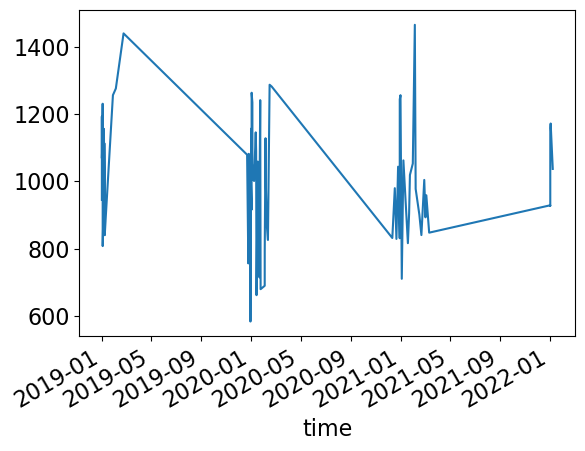

In [300]:
cso_methow['elevation'].plot()

In [17]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', 
                         groupby_col_aso='ASO_snowon_date', snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    # snwd['Muckamuck'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    # snwd['Salmon Meadows'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    snwd_65[snotel_list].plot(ax=ax, lw=2, color=color_list[0:len(snotel_list)])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='k', linewidth=0, marker='.')
    #snwd_65.iloc[:,0:9].plot(ax=ax, lw=2)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='lower right', title='SNOTEL Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

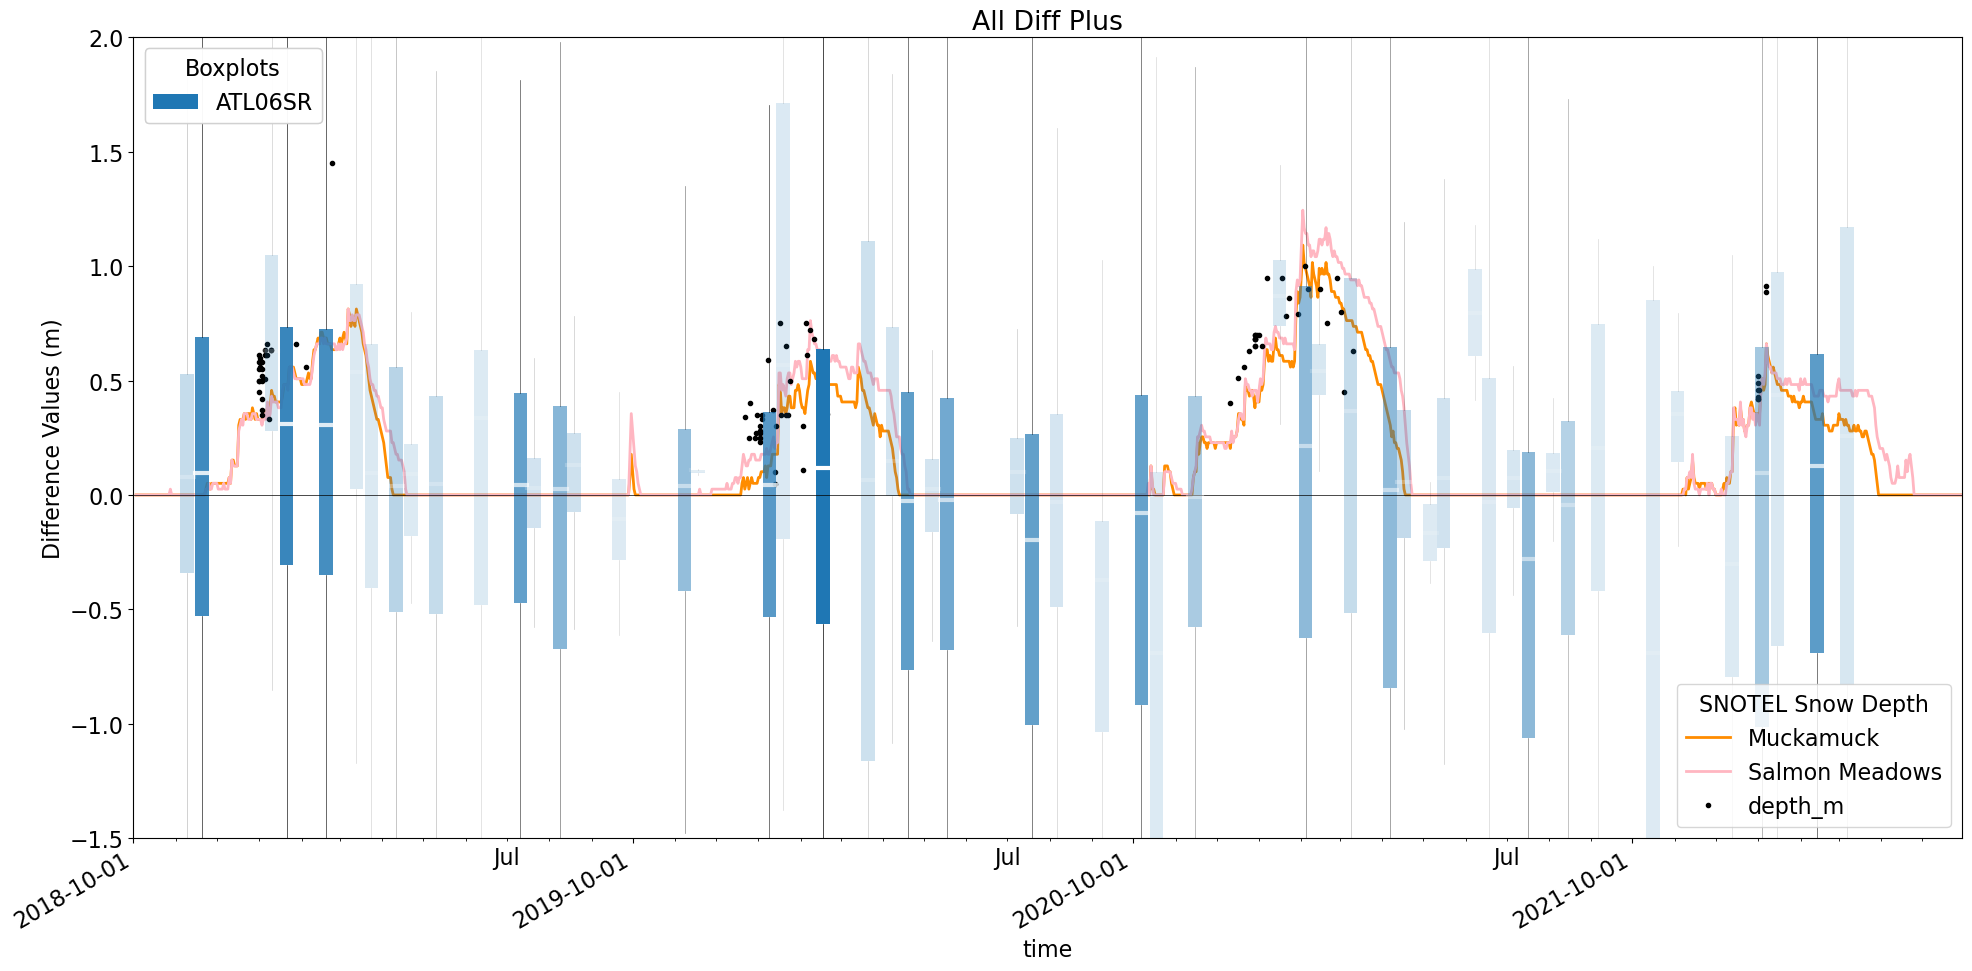

In [18]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1.5,2), name='boxplots_diffplus_transparent', title='All Diff Plus')

In [13]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', 
                         groupby_col_aso='ASO_snowon_date', snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    # snwd['Muckamuck'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    # snwd['Salmon Meadows'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    snwd_65[snotel_list].plot(ax=ax, lw=2, color=color_list[0:len(snotel_list)])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='k', linewidth=0, marker='.')
    #snwd_65.iloc[:,0:9].plot(ax=ax, lw=2)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='lower right', title='SNOTEL Snow Depth')
    #legend1.set_alpha(1)
    legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(1)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(0.8)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
    #     patch.set_alpha(0.8)
        
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    #plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [15]:
atl06sr_gdf.head()

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence,lidar_z,difference,lidar_z_20m,difference_20m,slope_3m,slope_20m,slope_100m,diff_plus,diff_plus_20m,zscore,n,diff_plus_lowslope,bicubic_lidar_z,sampling_dif,difference_bicubic,diff_plus_bicubic
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1496,NaN,NaN,NaN,NaN,NaN
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0,921.263184,-1.321359,924.401428,-4.459604,21.903059,11.596403,NaN,-0.881577,-4.024133,-0.667243,1496,-0.968813,921.309377,-0.046193,-1.367552,-0.927506
2018-11-09 22:09:43.794872008,0,918.460968,0.0,5,3.029108,0.046853,5.382943e+06,268445,-0.116342,646,1,2.703658e+07,20,31,0.240537,POINT (722140.182 5359280.079),2018-11-09,313,2018.857324,40,0,920.253967,-1.792999,916.323120,2.137848,20.189816,19.377096,17.052359,-1.353217,2.573319,-1.058617,1496,-1.440454,920.302309,-0.048342,-1.841341,-1.401294
2018-11-09 22:09:43.797684372,0,916.399163,0.0,5,3.000000,0.059160,5.382963e+06,268446,-0.091024,646,1,2.703658e+07,20,39,0.325805,POINT (722137.582 5359299.951),2018-11-09,313,2018.857324,40,0,916.869568,-0.470405,916.078796,0.320367,10.068434,15.654634,17.052359,-0.030623,0.755838,0.038892,1496,-0.117859,916.932254,-0.062686,-0.533091,-0.093044
2018-11-09 22:09:43.800494952,0,915.721672,0.0,5,3.000000,0.038990,5.382983e+06,268447,-0.027886,646,1,2.703658e+07,20,40,0.245902,POINT (722134.962 5359319.820),2018-11-09,313,2018.857324,40,0,917.229431,-1.507760,916.709717,-0.988045,7.963524,12.223098,17.052359,-1.067977,-0.552574,-0.821921,1496,-1.155214,917.339460,-0.110029,-1.617788,-1.177742


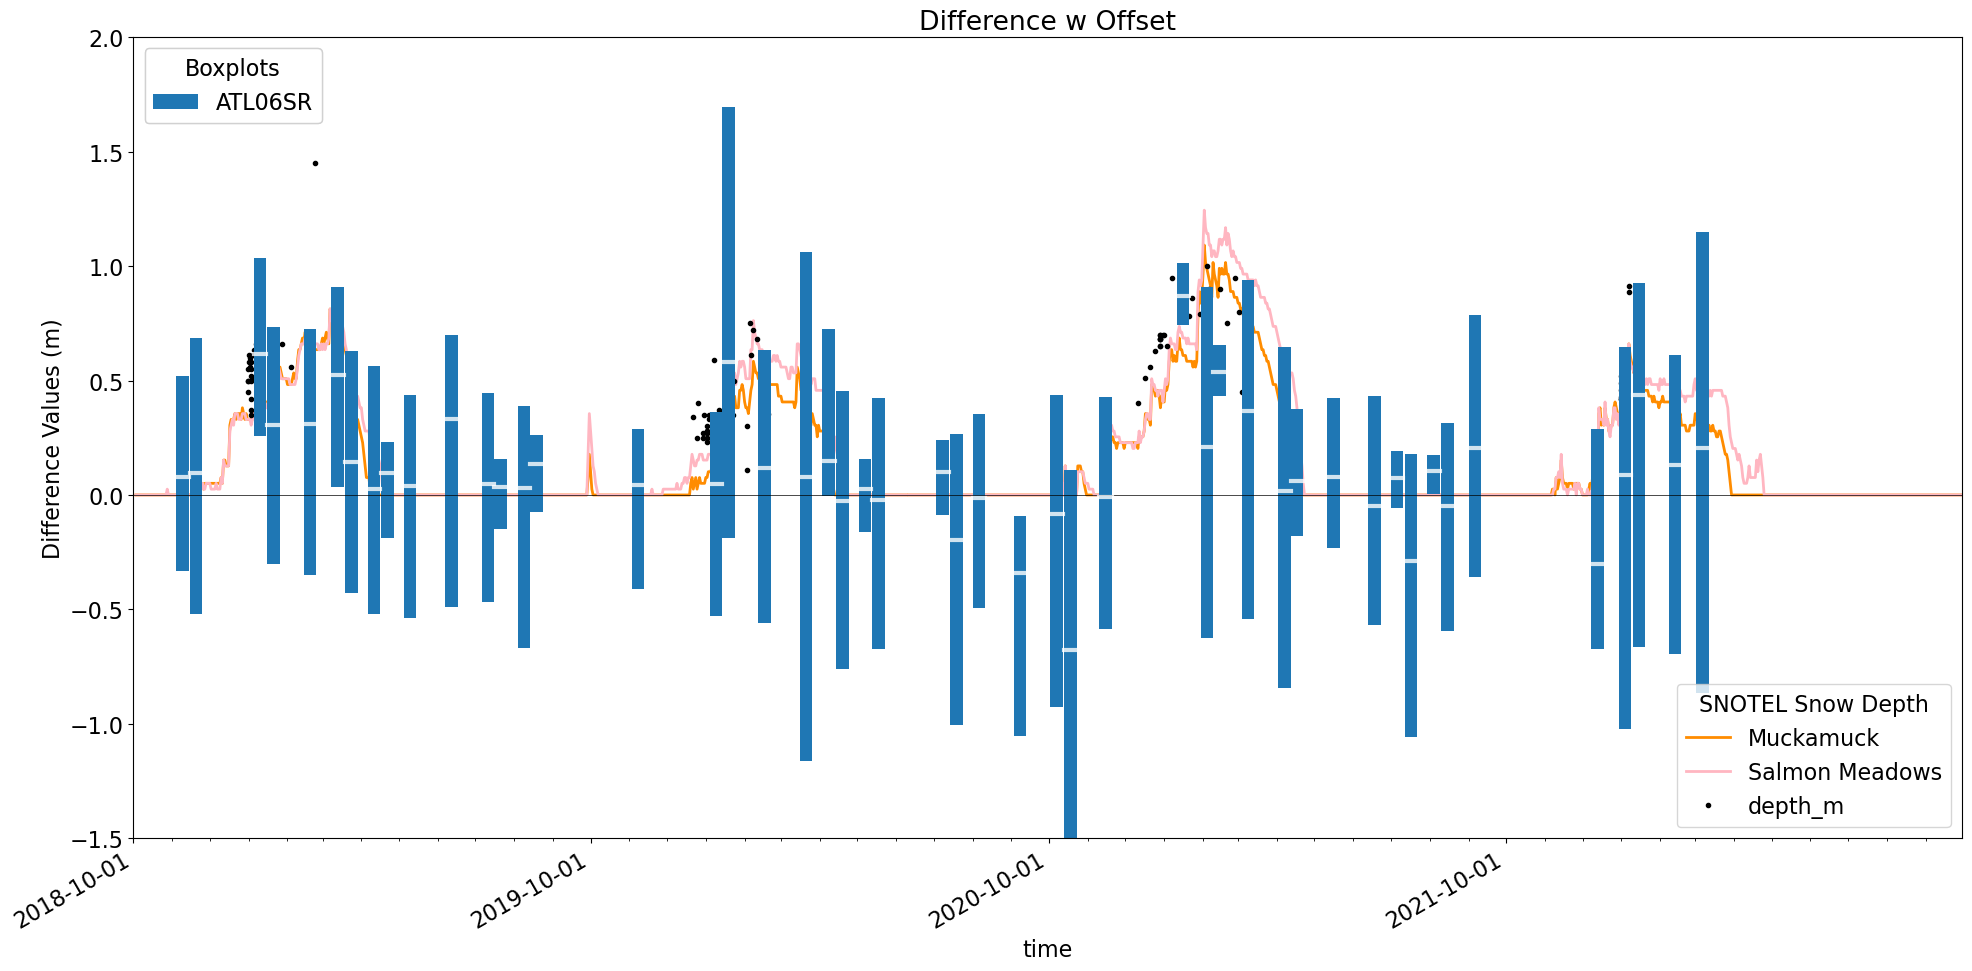

In [17]:
from matplotlib.lines import Line2D

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),]
    

custom_labels = ['Muckamuck', 'Salmon Meadows', 'Community Snow Observations', 'ATL06SR IQR', 'ATL06SR Median']
boxplot_date_aso_all(atl06sr_gdf, col='diff_plus_bicubic', clim=(-1.5,2))

In [23]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df=None, col=None, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    if df != None:
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, linestyle='--', color='darkorange')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='lightpink')
    if df != None:
        cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
                color='lightcoral', linewidth=0, marker='.', label='Community Snow Observations')
        ax.axes.get_xaxis().set_ticks([])
        ax.xaxis.set_ticklabels([])
        # Plot ATL06 data
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                       widths=10, patch_artist=True)
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='upper right', fontsize=16)
    
    # Set display keywords for the median lines on the boxplots
    if df != None:
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            patch.set_alpha(1)
            patch.set_color('black')  # or deeppink
            patch.set_linewidth(1.5)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=18)
    ax.set_xlabel('Acquisition Date', fontsize=18)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title('Methow Valley', fontsize=20)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
    # One attempt to remove the Jul xaxis label
    # x_axis = ax.axes.get_xaxis()
    # x_axis.set_label_text('foo')
    # x_label = x_axis.get_label()
    # x_label.set_visible(False)
    # Another attempt to remove the Jul xaxis label
    # ax.axes.get_xaxis().set_ticks([])
    # ax.xaxis.set_ticklabels([])
    
     # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]
    
    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))
    
    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=1.5, which='major')
    ax.tick_params('both', length=5, width=1.5, which='minor')
    ax.legend(custom, custom_labels, loc='upper right', prop={'size':16}) #, fontsize=10
    
#     years = mdates.MonthLocator(bymonth=(4, 10))
#     ax.format_xdata = mdates.DateFormatter('%b %d %Y')
#     years_fmt = mdates.DateFormatter('%b %d \n%Y')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
        
    #ax_dict['A'].annotate(text='I) Snow Depth and Difference Values (ATL06SR -DTM)', xy=(0.02,0.95), xycoords='axes fraction', weight='bold')
    
    # Plot the Landsat imagery below the timeseries plot
    
#     ax_dict['B'].imshow(fsca_dict['March 23 2019'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     ax_dict['B'].set_title('A) 2019')
#     ax_dict['B'].annotate(text='II) Landsat FSCA', xy=(0,1.2), xycoords='axes fraction', weight='bold')
    
#     ax_dict['C'].imshow(fsca_dict['March 9 2020'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     ax_dict['C'].set_title('B) 2020')
#     #ax_dict['C'].annotate(text='C)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['D'].imshow(fsca_dict['Feb 24 2021'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     ax_dict['D'].set_title('C) 2021')
#     #ax_dict['D'].annotate(text='D)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['E'].imshow(fsca_dict['Feb 11 2022'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     ax_dict['E'].set_title('D) 2022')
#     #ax_dict['E'].annotate(text='E)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     # Set axis color of lansat plots to match the vertical dashed lines, and remove
#     # axis ticks and labels. Also add a scalebar
#     for ax in [ax_dict['B'], ax_dict['C'], ax_dict['D'], ax_dict['E']]:
#         ax.spines['bottom'].set_color('lightgrey')
#         ax.spines['top'].set_color('lightgrey')
#         ax.spines['left'].set_color('lightgrey')
#         ax.spines['right'].set_color('lightgrey')
#         ax.axes.get_xaxis().set_ticks([])
#         ax.axes.get_yaxis().set_ticks([])
#     ax_dict['B'].add_artist(ScaleBar(1, font_properties={'size':8}))
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

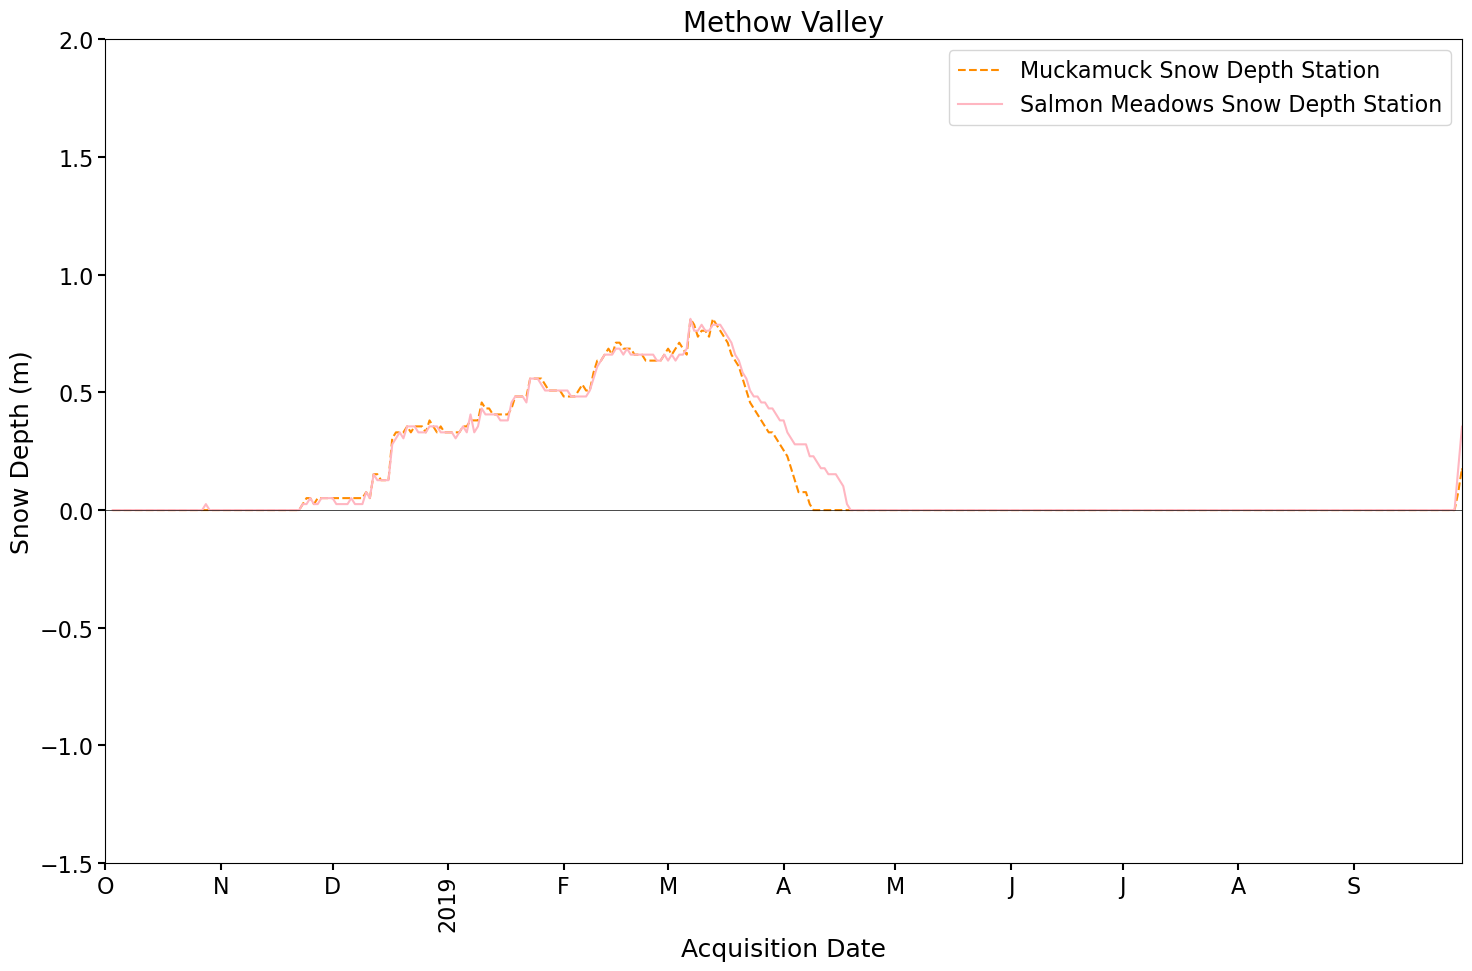

In [79]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          ]
    

custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_landsat(clim=(-1.5,2), name='boxplots_diffplus_snotel_pres', title='All Diff Plus')

In [26]:
from datetime import datetime

In [44]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df=None, col=None, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    if df != None:    
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, linestyle='--', color='darkorange')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='lightpink')
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='lightcoral', linewidth=0, marker='.', label='Community Snow Observations')
    ax.axes.get_xaxis().set_ticks([])
    ax.xaxis.set_ticklabels([])
    # Plot ATL06 data
    if df != None:
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                       widths=10, patch_artist=True)
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='upper right', fontsize=18)
    
    # Set display keywords for the median lines on the boxplots
    if df != None:
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            patch.set_alpha(1)
            patch.set_color('black')  # or deeppink
            patch.set_linewidth(1.5)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=20)
    ax.set_xlabel('Acquisition Date', fontsize=20)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title('Methow Valley', fontsize=24)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
         # Creating the custom xtick labels that I want
    if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
        months = mdates.MonthLocator()
        #ax.format_xdata = mdates.DateFormatter('%B')
        months_fmt = mdates.DateFormatter('%B')
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(months_fmt)
        months = mdates.MonthLocator()
        #ax.xaxis.set_minor_locator(months)
        #ax.xaxis.set_minor_formatter(months_fmt)        
        #ax.format_xdata = mdates.DateFormatter('%B-%Y')
    else:
        # X AXIS LABELS     
        months = mdates.MonthLocator()
        month_fmt = mdates.DateFormatter('%b')

        def m_fmt(x, pos=None):
            return month_fmt(x)[0]

        ax.xaxis.set_minor_locator(months) 
        ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))

        years = mdates.MonthLocator(bymonth=1)
        ax.format_xdata = mdates.DateFormatter('%Y')
        years_fmt = mdates.DateFormatter('%Y')
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    
#     ax_dict['B'].imshow(fsca_dict['March 23 2019'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
#     ax_dict['B'].set_title('A) 2019')
#     ax_dict['B'].annotate(text='II) Landsat FSCA', xy=(0,1.2), xycoords='axes fraction', weight='bold')
    
#     ax_dict['C'].imshow(fsca_dict['March 9 2020'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
#     ax_dict['C'].set_title('B) 2020')
#     #ax_dict['C'].annotate(text='C)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['D'].imshow(fsca_dict['Feb 24 2021'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
#     ax_dict['D'].set_title('C) 2021')
#     #ax_dict['D'].annotate(text='D)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     ax_dict['E'].imshow(fsca_dict['Feb 11 2022'], extent=window_extent)
#     outline_gdf.plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     snotel_geom_5km[2:].plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
#     ax_dict['E'].set_title('D) 2022')
#     #ax_dict['E'].annotate(text='E)', xy=(-0.12,0.9), xycoords='axes fraction')
    
#     # Set axis color of lansat plots to match the vertical dashed lines, and remove
#     # axis ticks and labels. Also add a scalebar
#     for ax in [ax_dict['B'], ax_dict['C'], ax_dict['D'], ax_dict['E']]:
#         ax.spines['bottom'].set_color('lightgrey')
#         ax.spines['top'].set_color('lightgrey')
#         ax.spines['left'].set_color('lightgrey')
#         ax.spines['right'].set_color('lightgrey')
#         ax.axes.get_xaxis().set_ticks([])
#         ax.axes.get_yaxis().set_ticks([])
#     ax_dict['B'].add_artist(ScaleBar(1, font_properties={'size':8}))
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

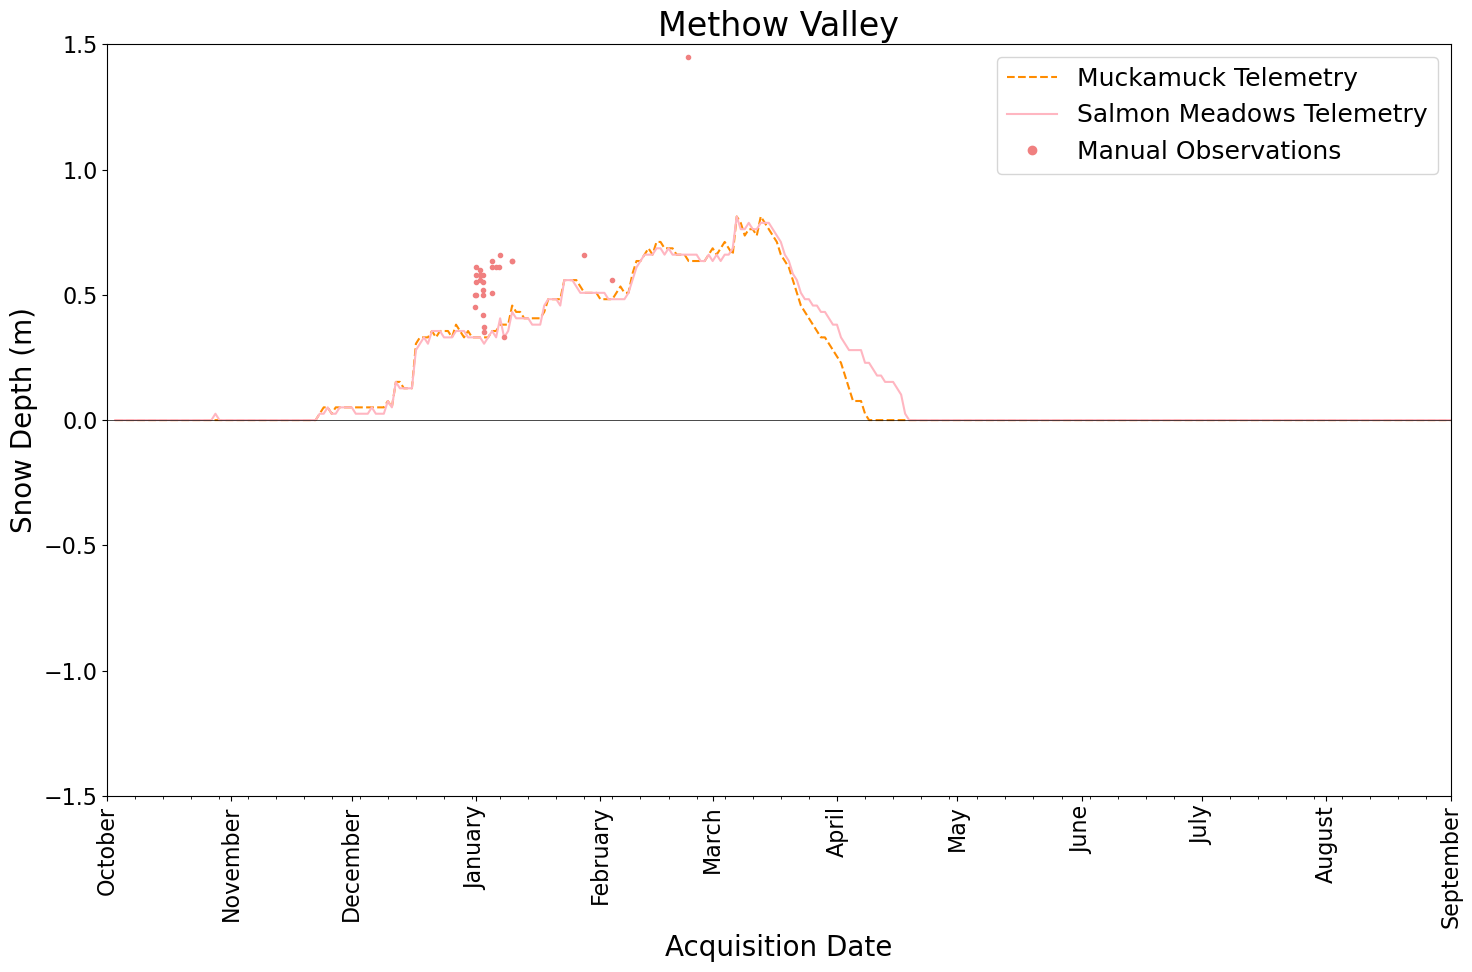

In [45]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          ]
    

custom_labels = ['Muckamuck Telemetry', 'Salmon Meadows Telemetry', 'Manual Observations']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-01'
boxplot_date_landsat(clim=(-1.5,1.5), name='boxplots_diffplus_snotel_cso_pres', title='All Diff Plus')

In [42]:
snwd

,Muckamuck,Salmon Meadows,doy,decyear,dowy,acqdate
2018-10-03,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0,0.0,277,2018.756164,4,2018-10-04
2018-10-05,0.0,0.0,278,2018.758904,5,2018-10-05
2018-10-06,0.0,0.0,279,2018.761644,6,2018-10-06
2018-10-07,0.0,0.0,280,2018.764384,7,2018-10-07
...,...,...,...,...,...,...
2022-10-14,0.0,0.0,287,2022.783562,14,2022-10-14
2022-10-15,0.0,0.0,288,2022.786301,15,2022-10-15
2022-10-16,0.0,0.0,289,2022.789041,16,2022-10-16
2022-10-17,0.0,0.0,290,2022.791781,17,2022-10-17


<AxesSubplot: >

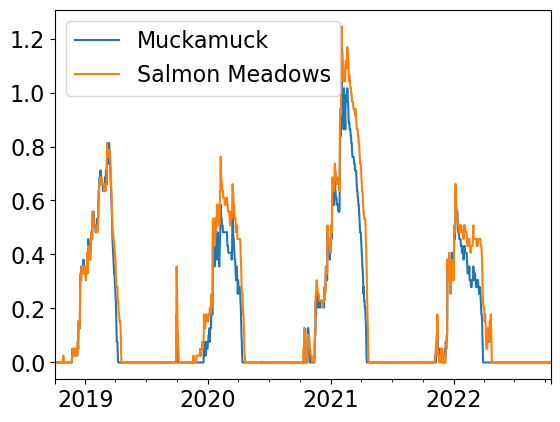

In [47]:
snwd_ms.plot()

In [17]:
snwd_ms = snwd.drop(columns=['doy','decyear', 'dowy', 'acqdate'])

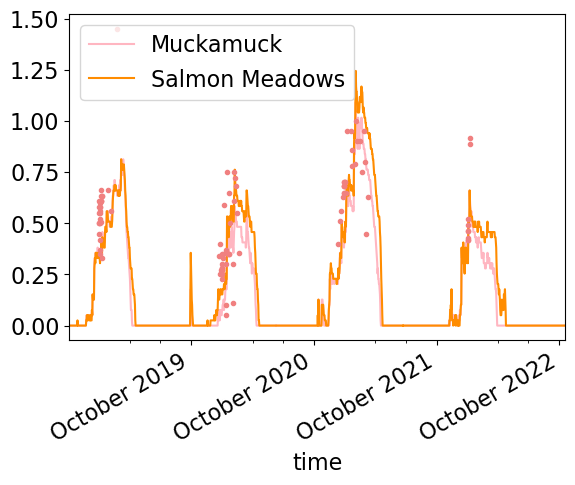

In [63]:
cso_bounds=[0,3000]
fig, ax = plt.subplots()
snwd_ms.plot(ax=ax, lw=1.5, color = ['lightpink','darkorange'])
cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
            color='lightcoral', linewidth=0, marker='.', label='Community Snow Observations')
ax.axes.get_xaxis().set_ticks([])
years = mdates.YearLocator(month=10)
years_fmt = mdates.DateFormatter('%B %Y')
#ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
#years_fmt = mdates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

<AxesSubplot: >

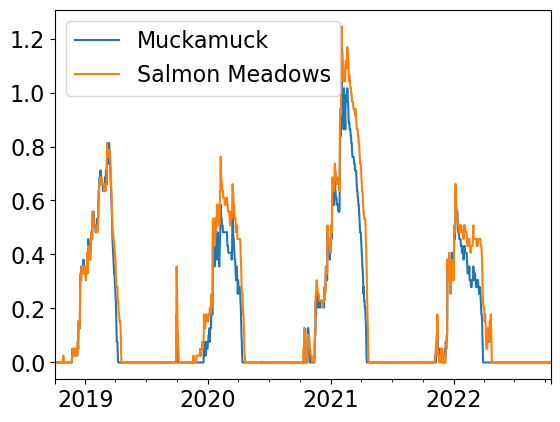

In [47]:
snwd[snotel_list].plot()

In [38]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)
plt.rcParams['font.size'] = '16'
def boxplot_date_landsat(df, col, groupby_col='acqdate', 
                         snotel_list=['Muckamuck', 'Salmon Meadows'], 
                         cso_bounds=[0,3000], 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    f, ax = plt.subplots(figsize=(15,10))
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    #snwd_65[snotel_list].plot(ax=ax_dict['A'], lw=1.5, color='darkorange)
    # snwd['Muckamuck'].plot(ax=ax, lw=1.5, color='lightpink')
    # snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color='darkorange')
    snwd['Muckamuck'].plot(ax=ax, lw=1.5, color = 'darkorange', linestyle='--')
    snwd['Salmon Meadows'].plot(ax=ax, lw=1.5, color = 'lightpink', linestyle='-')
    #snwd[snotel_list].plot(ax=ax, lw=1.5, color = ['darkorange', 'lightpink'], linestyle=['--', '-'])
    cso_methow[(cso_methow['elevation']>cso_bounds[0]) & (cso_methow['elevation']<cso_bounds[1])]['depth_m'].plot(ax=ax, \
                color='lightcoral', linewidth=0, marker='.', label='CSO Probe Measurements')
    ax.axes.get_xaxis().set_ticks([])
    years = mdates.YearLocator(month=10)
    years_fmt = mdates.DateFormatter('%B %Y')
    #ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
    #years_fmt = mdates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                   widths=10, medianprops={'lw':1.5, 'color':'k'}, patch_artist=True) #
    
    # Create my custom legend
    ax.legend(custom, custom_labels, loc='lower left', prop={'size':18}, fancybox=True, framealpha=0.5)
    
    # Set display keywords for the median lines on the boxplots
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(1)
        patch.set_color('black')  # or deeppink
        patch.set_linewidth(2)
    
    # Plot vertical lines for each landsat acquisition date
    # for date1 in dates[1:]:
    #     ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)', fontsize=22)
    ax.set_xlabel('Acquisition Date', fontsize=22)
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.axes.get_xaxis().set_ticks([])
    plt.xticks(color='w')
    plt.title('Methow Valley, Wa', fontsize=24)
    #ax_dict['A'].set_title(title) 
    #ax.set_xlabel('')
    
    # if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
    #     months = mdates.MonthLocator()
    #     #ax.format_xdata = mdates.DateFormatter('%B')
    #     months_fmt = mdates.DateFormatter('%B')
    #     ax.xaxis.set_major_locator(months)
    #     ax.xaxis.set_major_formatter(months_fmt)
    #     months = mdates.MonthLocator()
    #     #ax.xaxis.set_minor_locator(months)
    #     #ax.xaxis.set_minor_formatter(months_fmt)        
    #     #ax.format_xdata = mdates.DateFormatter('%B-%Y')
    # else:
    # X AXIS LABELS     
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')

    def m_fmt(x, pos=None):
        return month_fmt(x)[0]

    ax.xaxis.set_minor_locator(months) 
    ax.xaxis.set_minor_formatter(FuncFormatter(m_fmt))

    years = mdates.MonthLocator(bymonth=1)
    ax.format_xdata = mdates.DateFormatter('%Y')
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.tick_params('both', length=5, width=2, which='major')
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=90, horizontalalignment='center')
    
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [30]:
from matplotlib.ticker import FuncFormatter

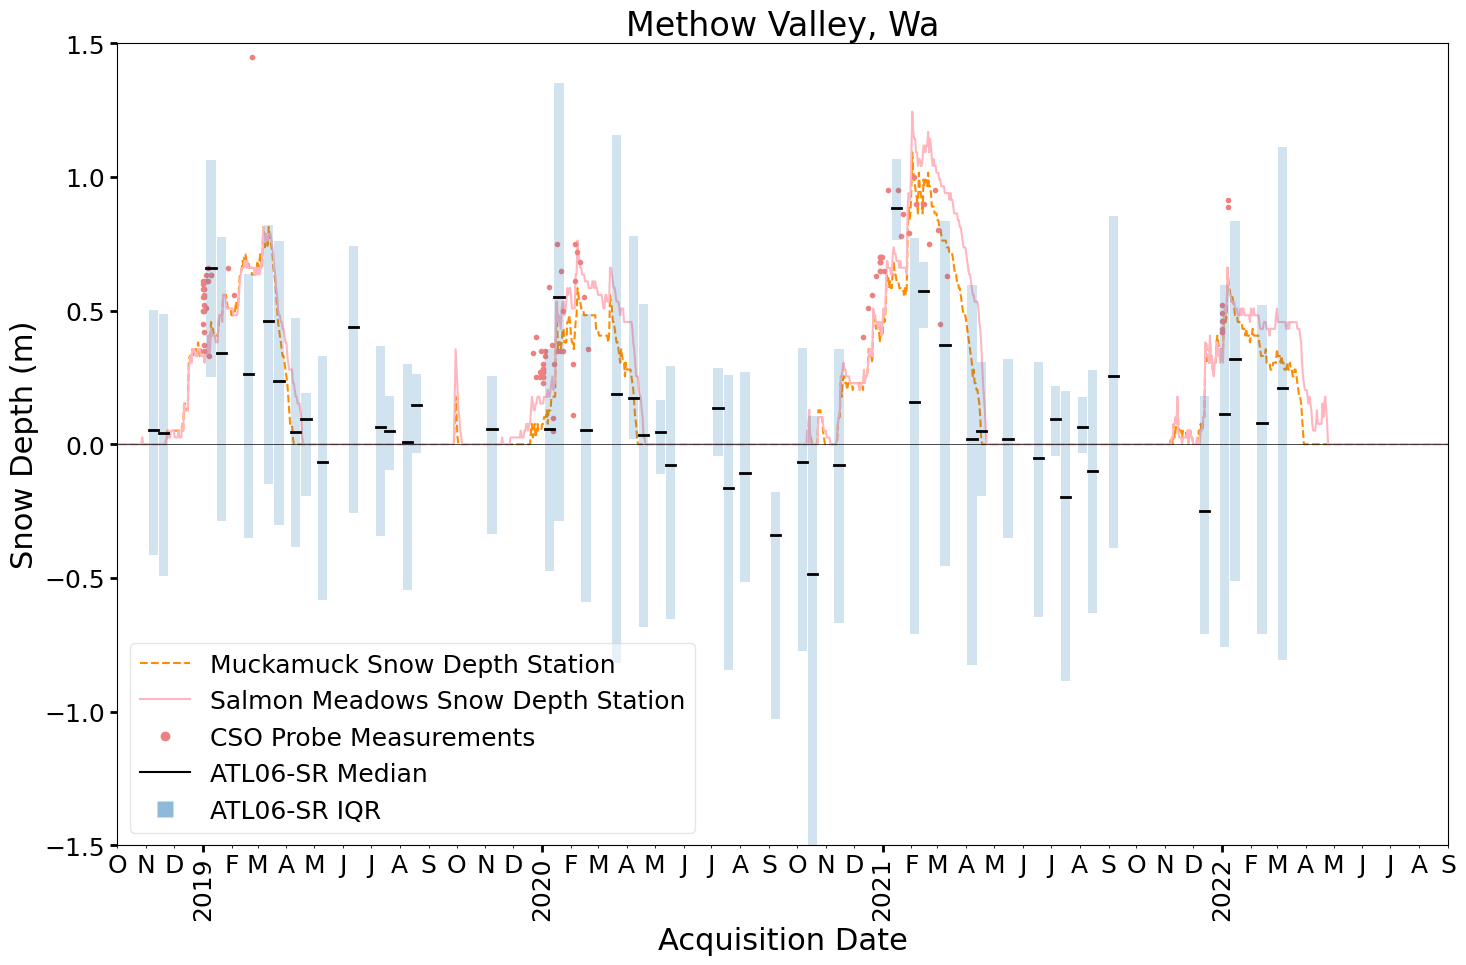

In [39]:
from matplotlib.lines import Line2D
from datetime import datetime

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
    
plt.rcParams['font.size'] = '18'
custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station', 'CSO Probe Measurements', 'ATL06-SR Median', 'ATL06-SR IQR'] #'CSO Probe Measurements',

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-01'
boxplot_date_landsat(df=atl06sr_gdf_inner, col='diff_plus_bicubic', clim=(-1.5,1.5), name='boxplots_diffplus_snotel_cso_atl06sr_paper_dates', title='All Diff Plus')

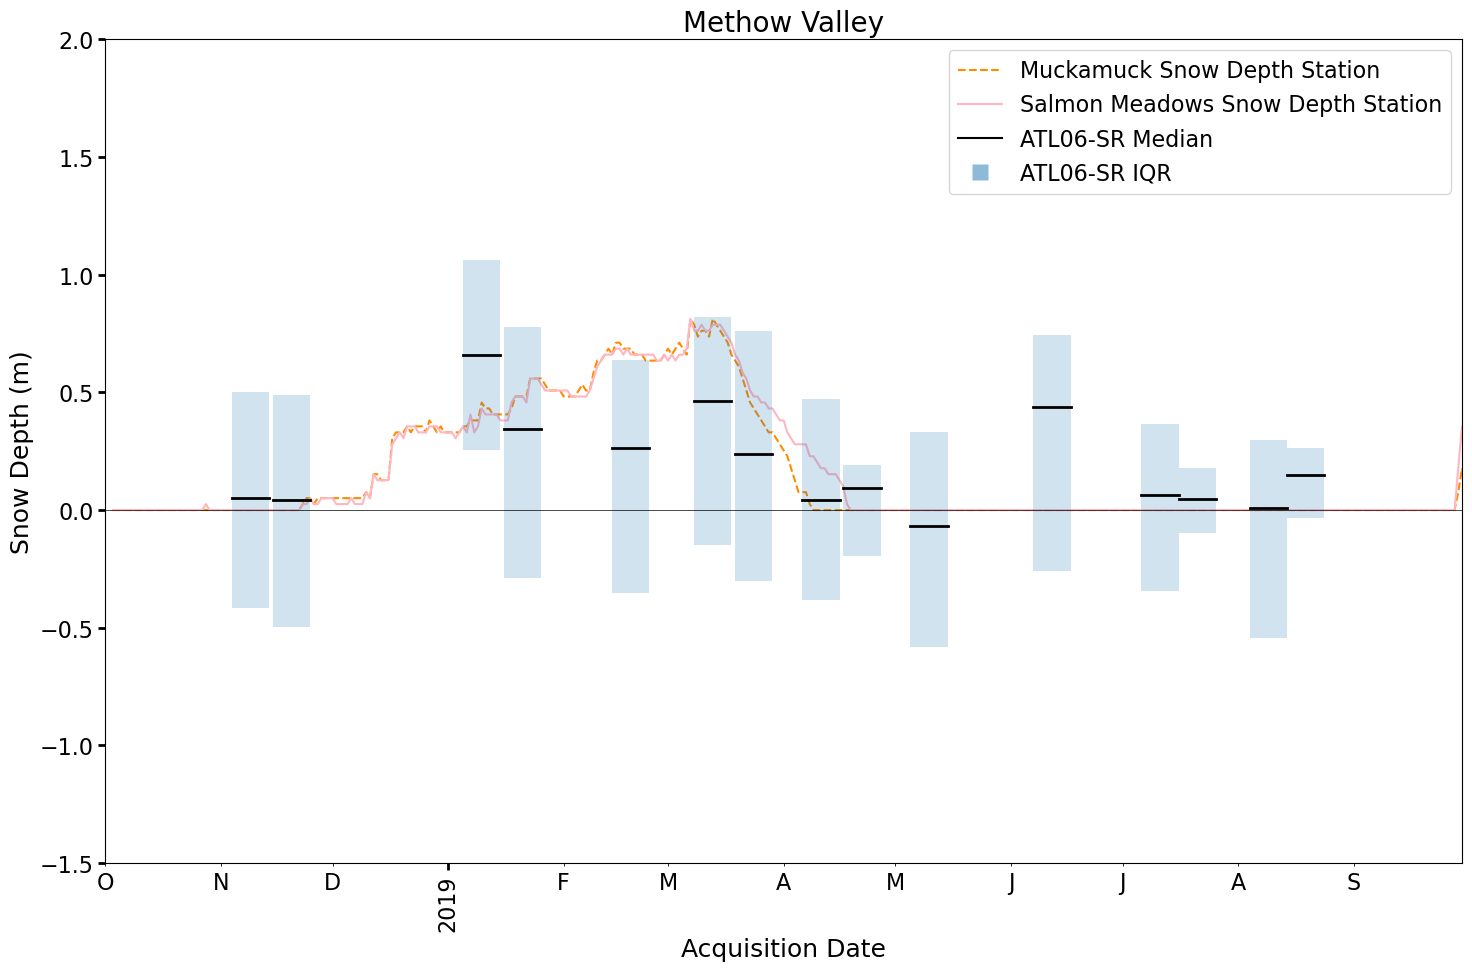

In [76]:
from matplotlib.lines import Line2D
from datetime import datetime

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='--', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          #Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
    

custom_labels = ['Muckamuck Snow Depth Station', 'Salmon Meadows Snow Depth Station', 'ATL06-SR Median', 'ATL06-SR IQR'] #'CSO Probe Measurements',

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_landsat(df=atl06sr_gdf_inner, col='diff_plus_bicubic', clim=(-1.5,2), name='boxplots_diffplus_snotel_atl06sr_2019_pres', title='All Diff Plus')

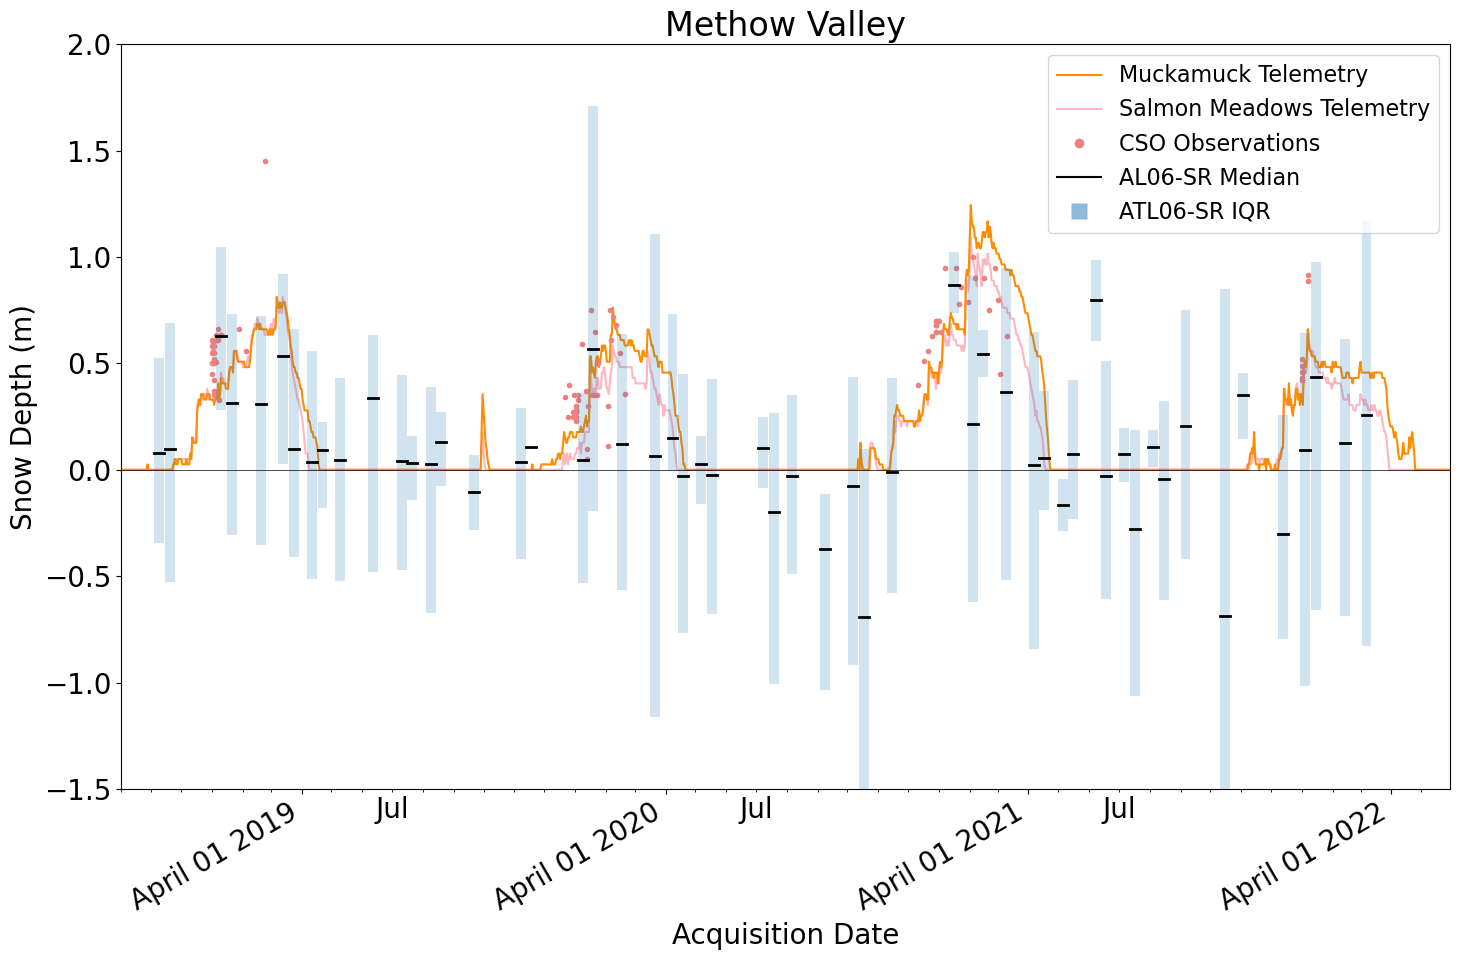

In [21]:
from matplotlib.lines import Line2D
from datetime import datetime

plt.rcParams['font.size'] = '20'

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='-', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          Line2D([], [], marker='.', markersize=12, color='lightcoral', linestyle='None'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
    

custom_labels = ['Muckamuck Telemetry', 'Salmon Meadows Telemetry', 'CSO Observations', 'AL06-SR Median', 'ATL06-SR IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_landsat(df=atl06sr_gdf, col='diff_plus', clim=(-1.5,2), name='boxplots_diffplus_snotel_cso_atl06sr_paper', title='All Diff Plus')

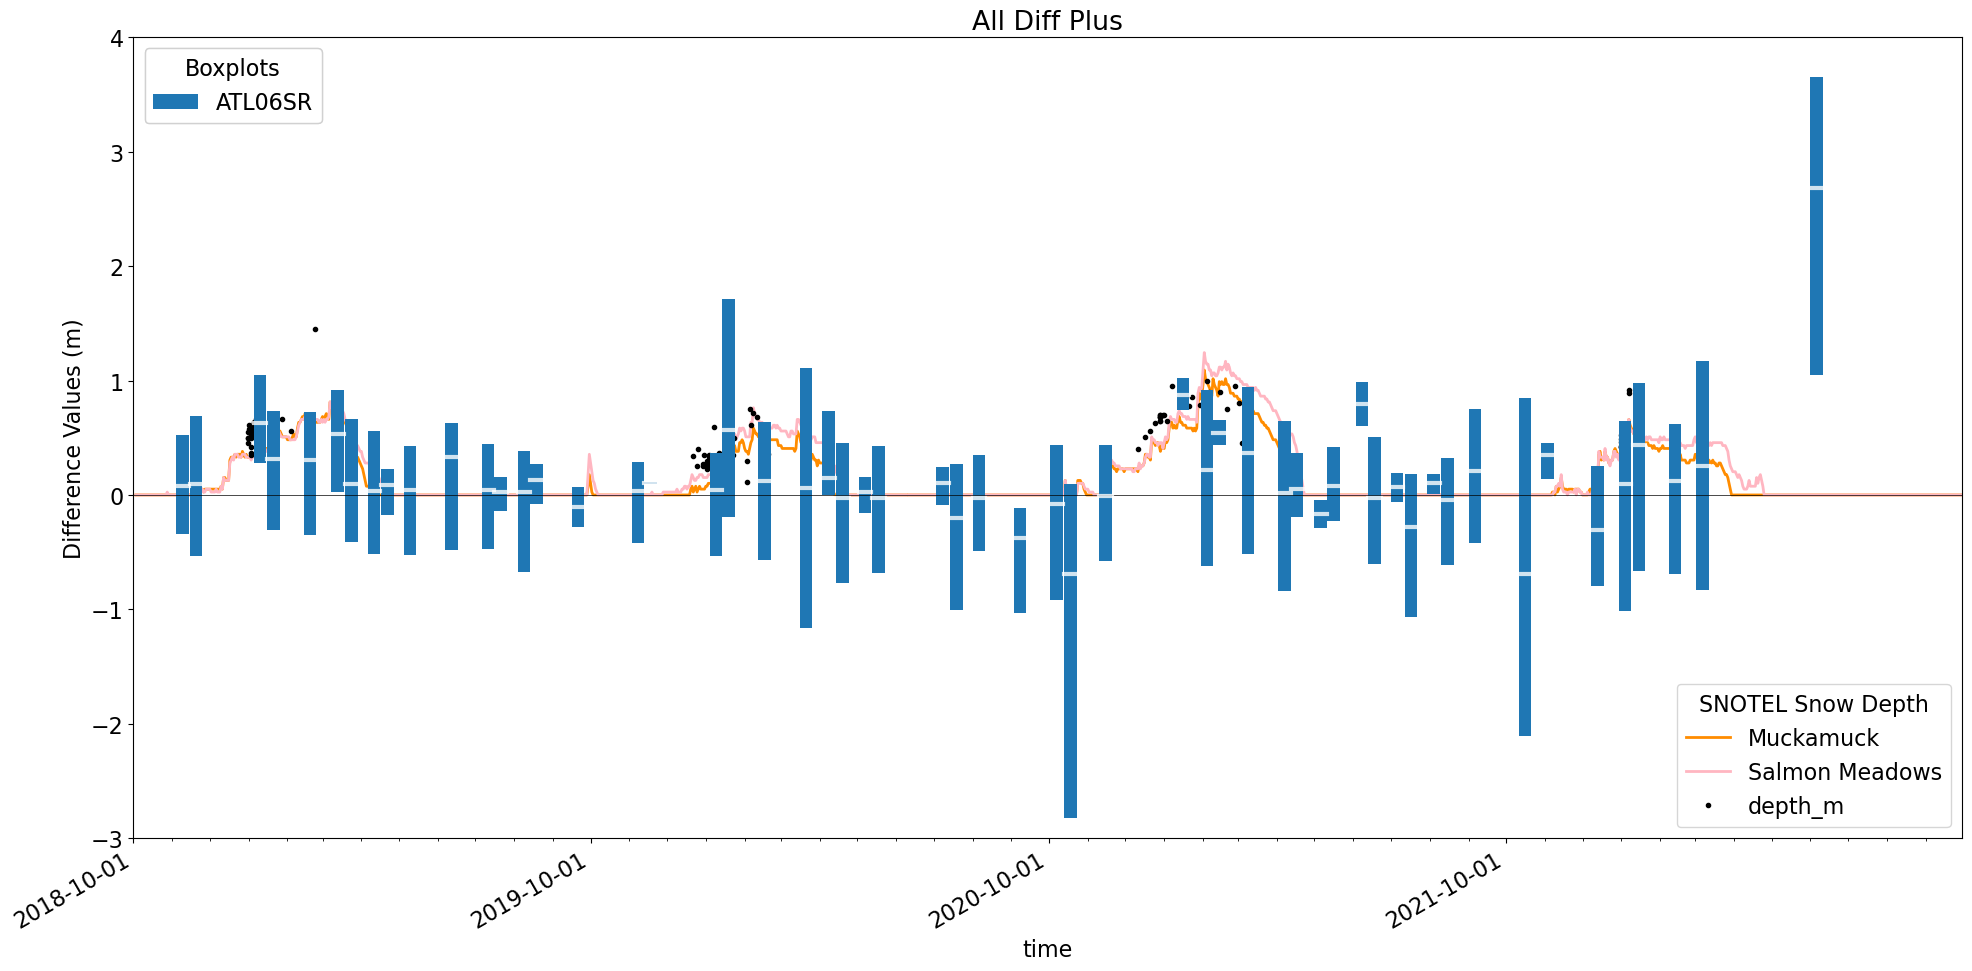

In [364]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-3,4), name='boxplots_diffplus', title='All Diff Plus')

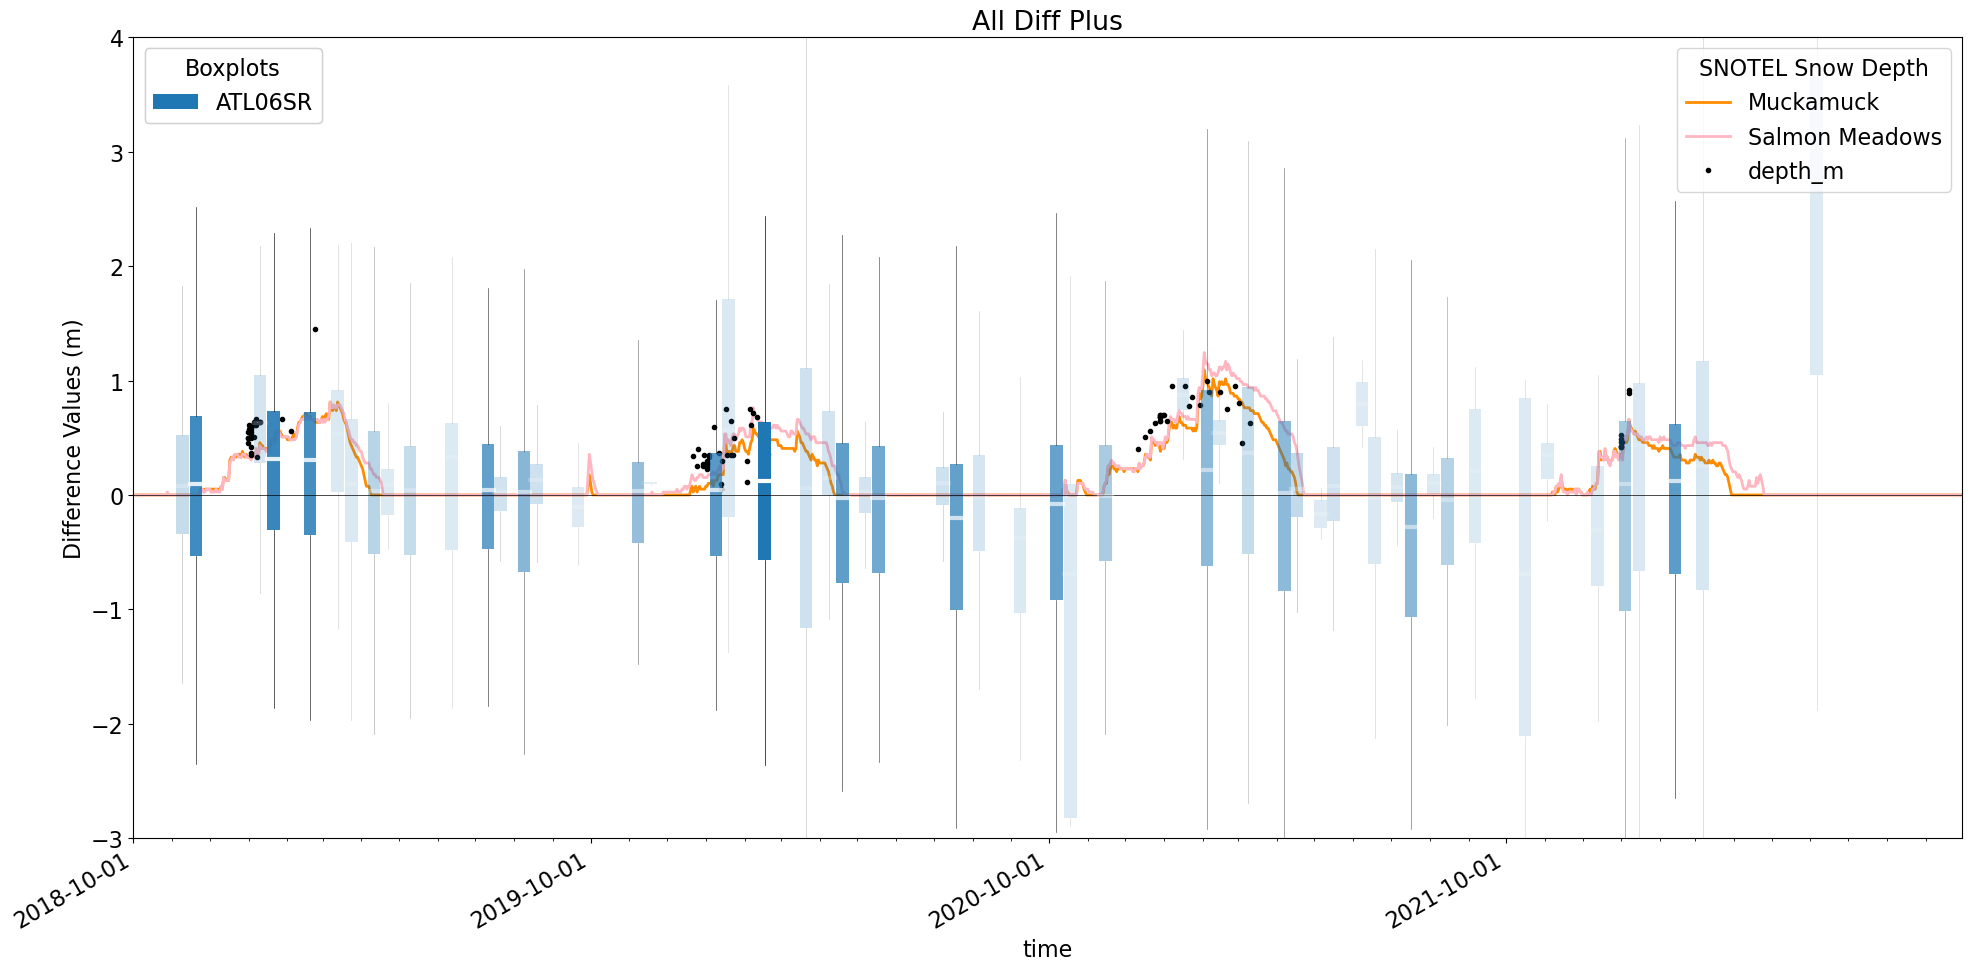

In [295]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-3,4), name='boxplots_diffplus', title='All Diff Plus')

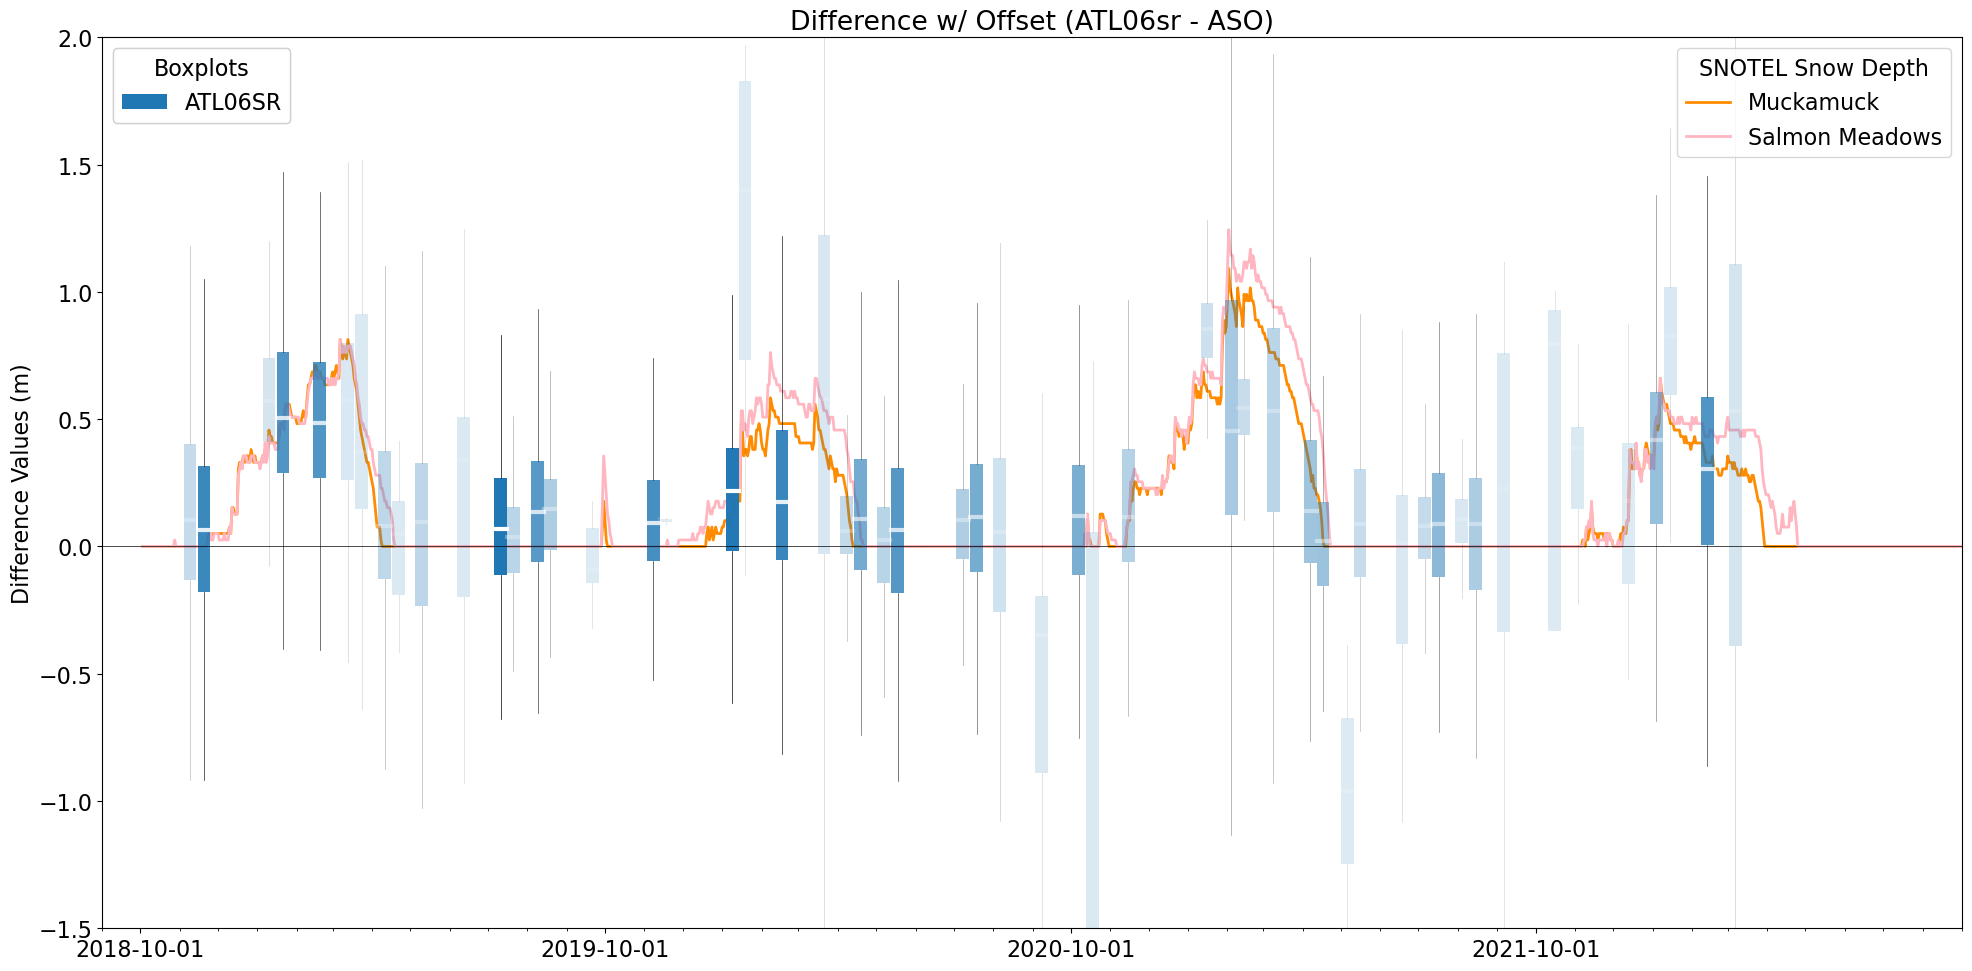

In [237]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus', clim=(-1.5,2), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_slope10')

# Separate Diff Plus by Elevation

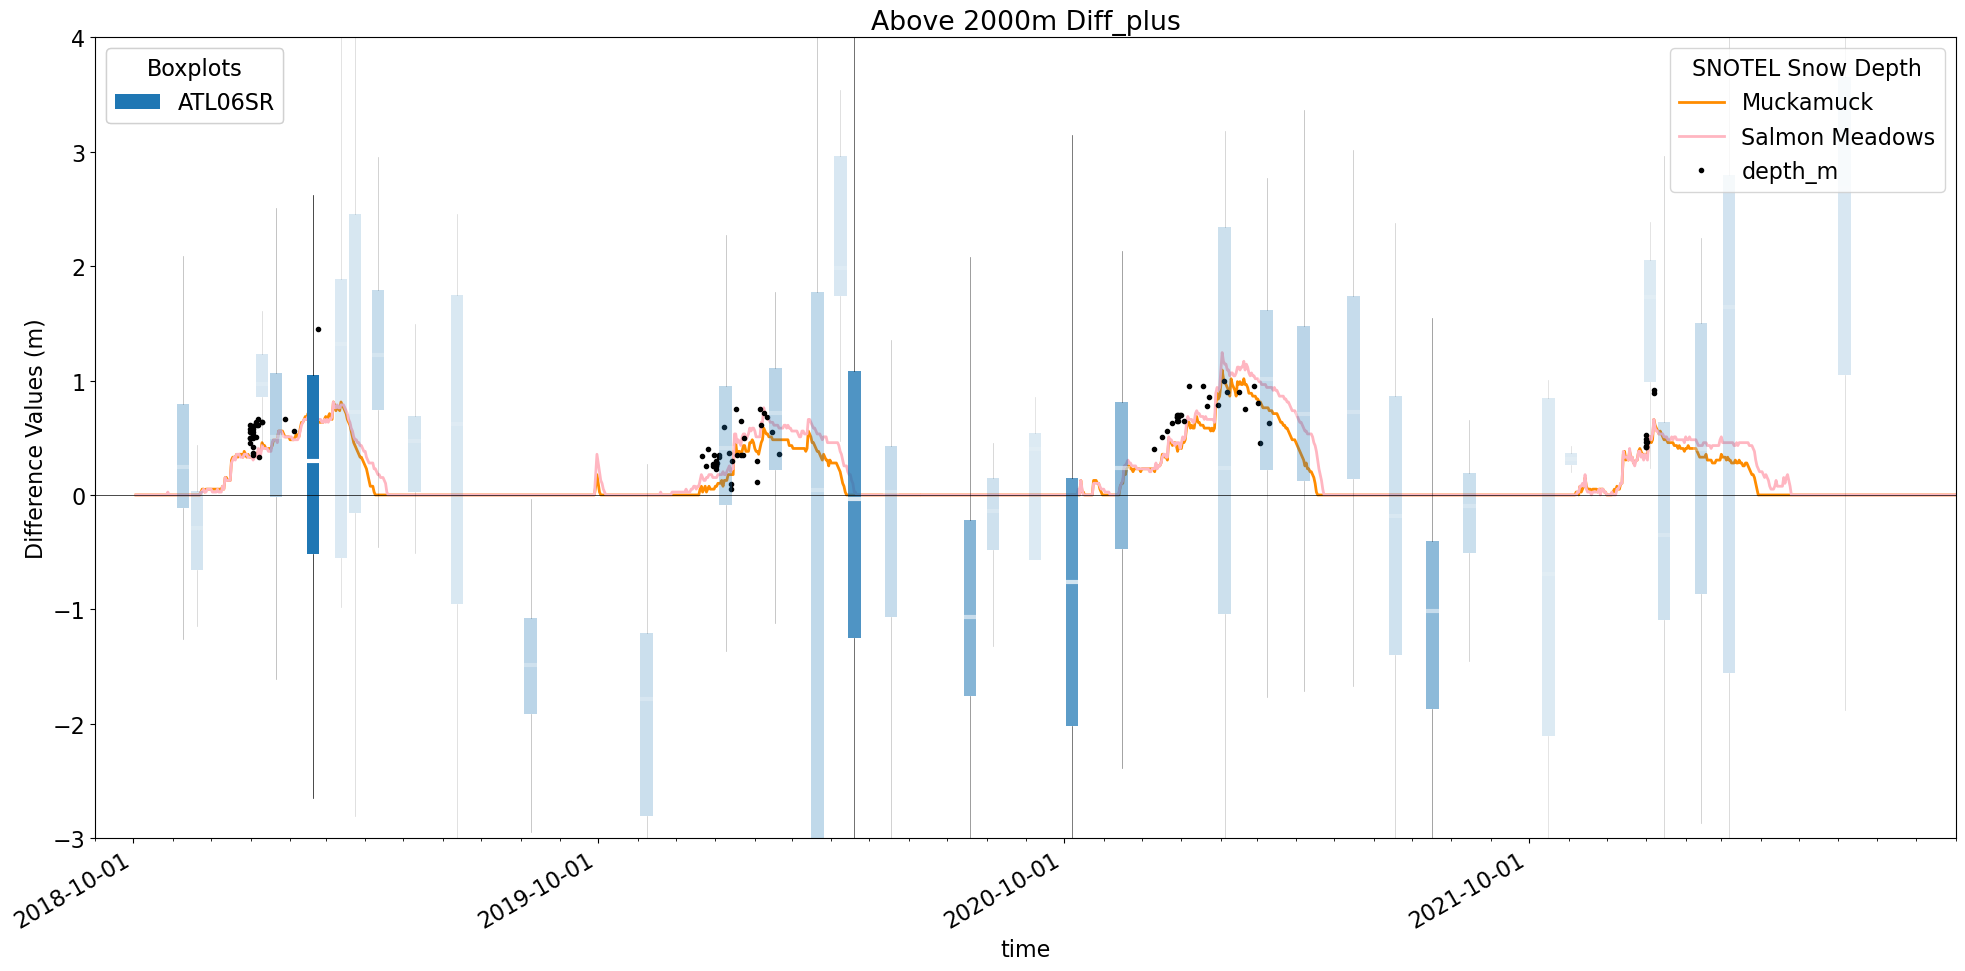

In [297]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['lidar_z']>2000], 'diff_plus', clim=(-3,4), title = 'Above 2000m Diff_plus', name = 'boxplots_diffplus_slope10')

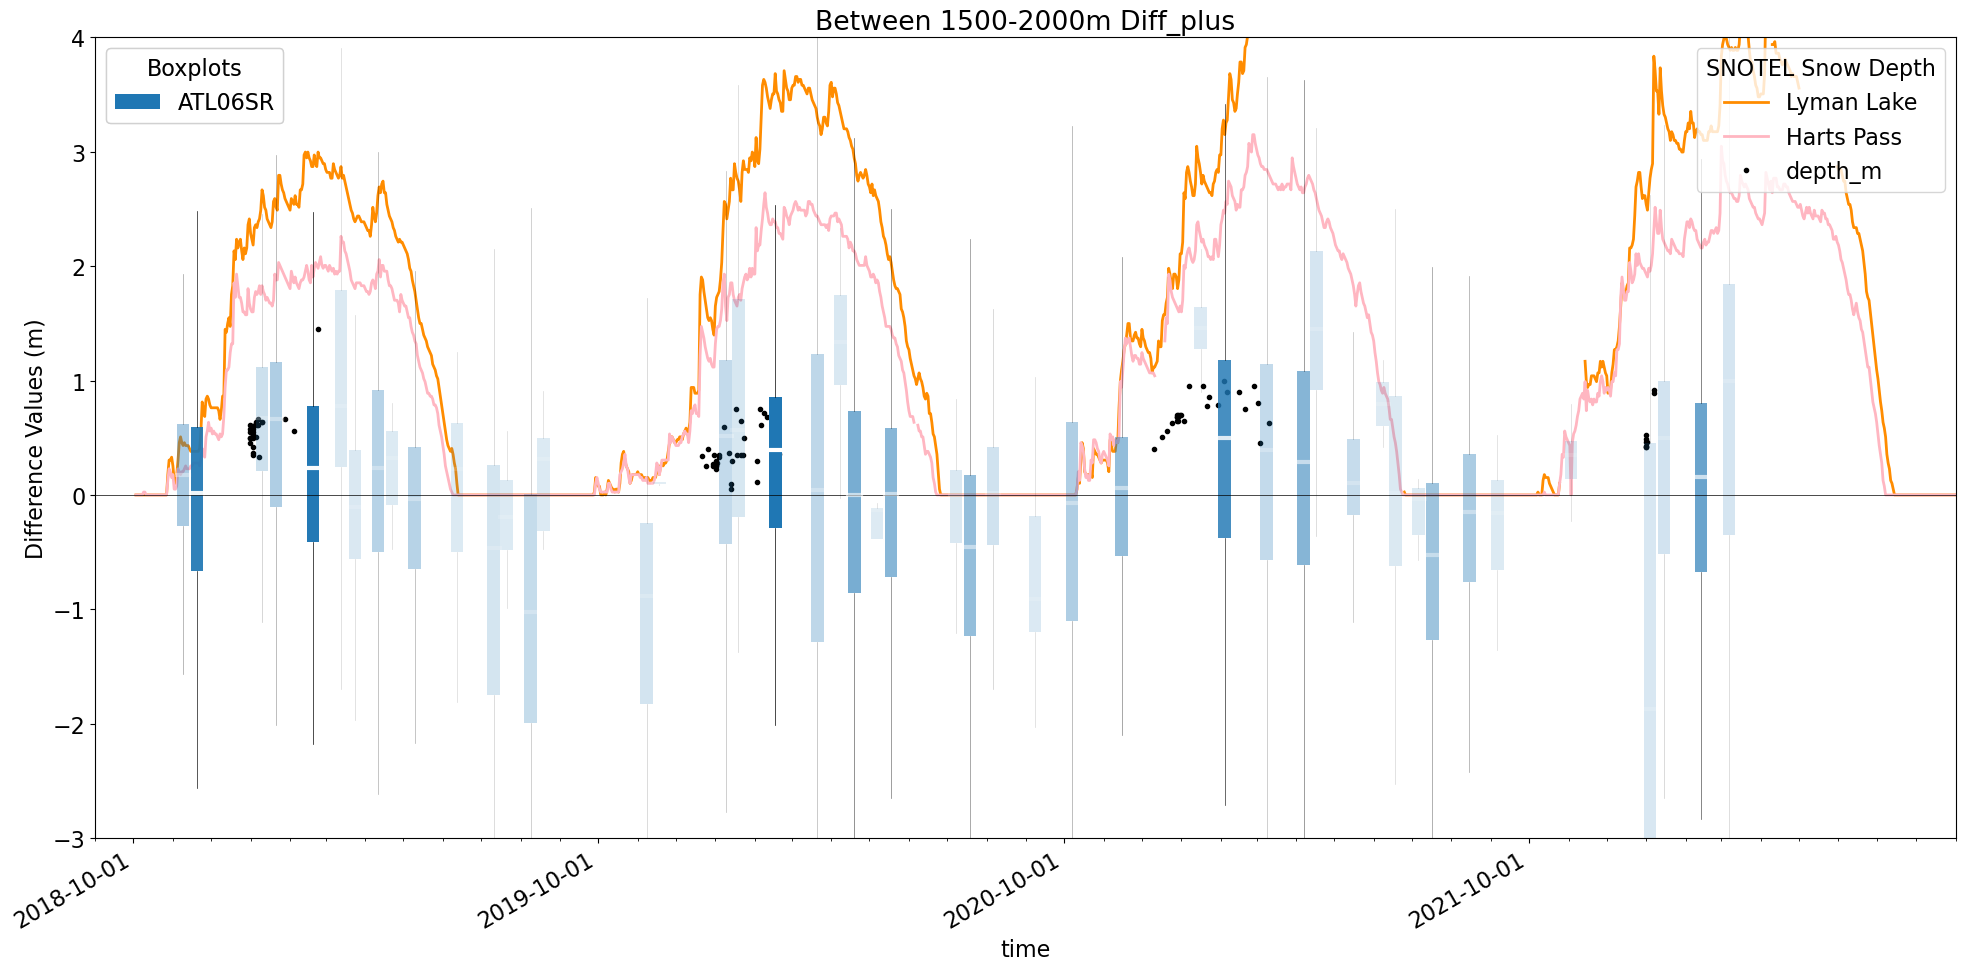

In [301]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<2000) & (atl06sr_gdf['lidar_z']>1500)], 'diff_plus', snotel_list=snotel_sites[snotel_sites['elevation_m']>1500]['name'], clim=(-3,4), title = 'Between 1500-2000m Diff_plus', name = 'boxplots_diffplus_slope10')

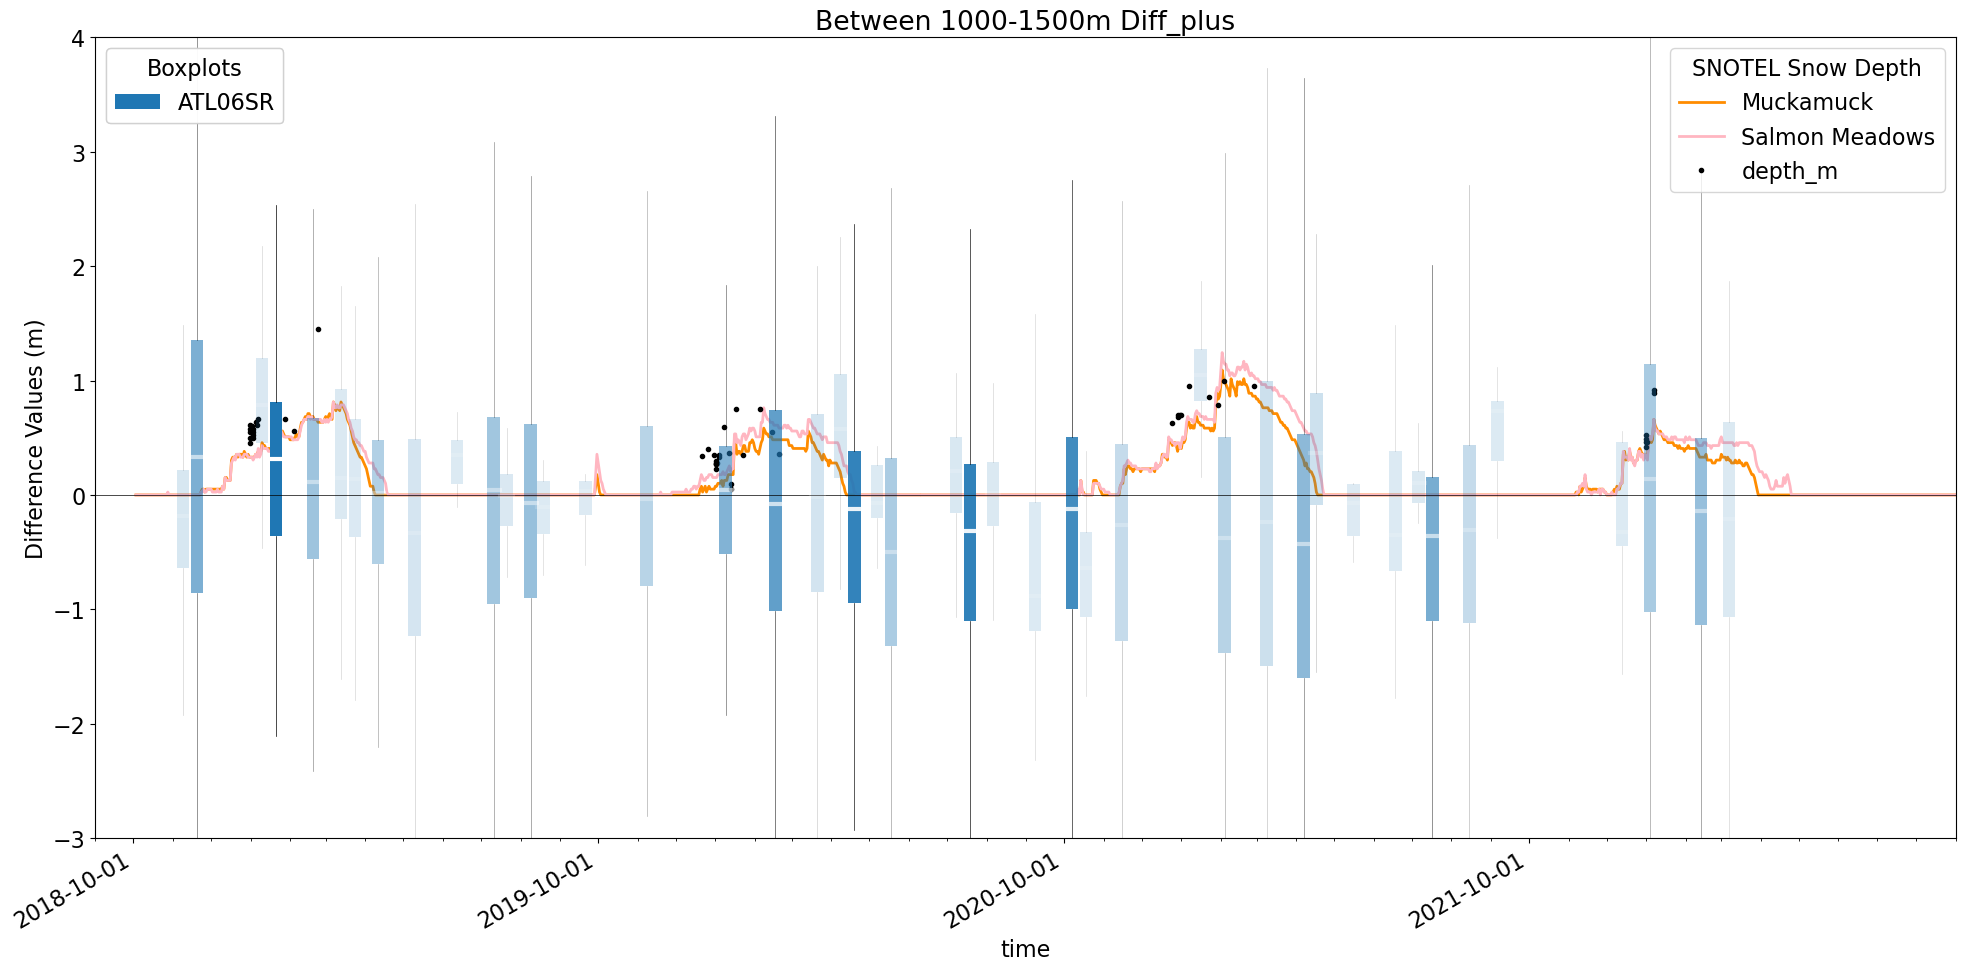

In [302]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1500) & (atl06sr_gdf['lidar_z']>1000)], 'diff_plus', cso_bounds=[1000, 1500], clim=(-3,4), title = 'Between 1000-1500m Diff_plus', name = 'boxplots_diffplus_slope10')
# snotel_list=snotel_sites[(snotel_sites['elevation_m']<1500) & (snotel_sites['elevation_m']>1000)]['name'],

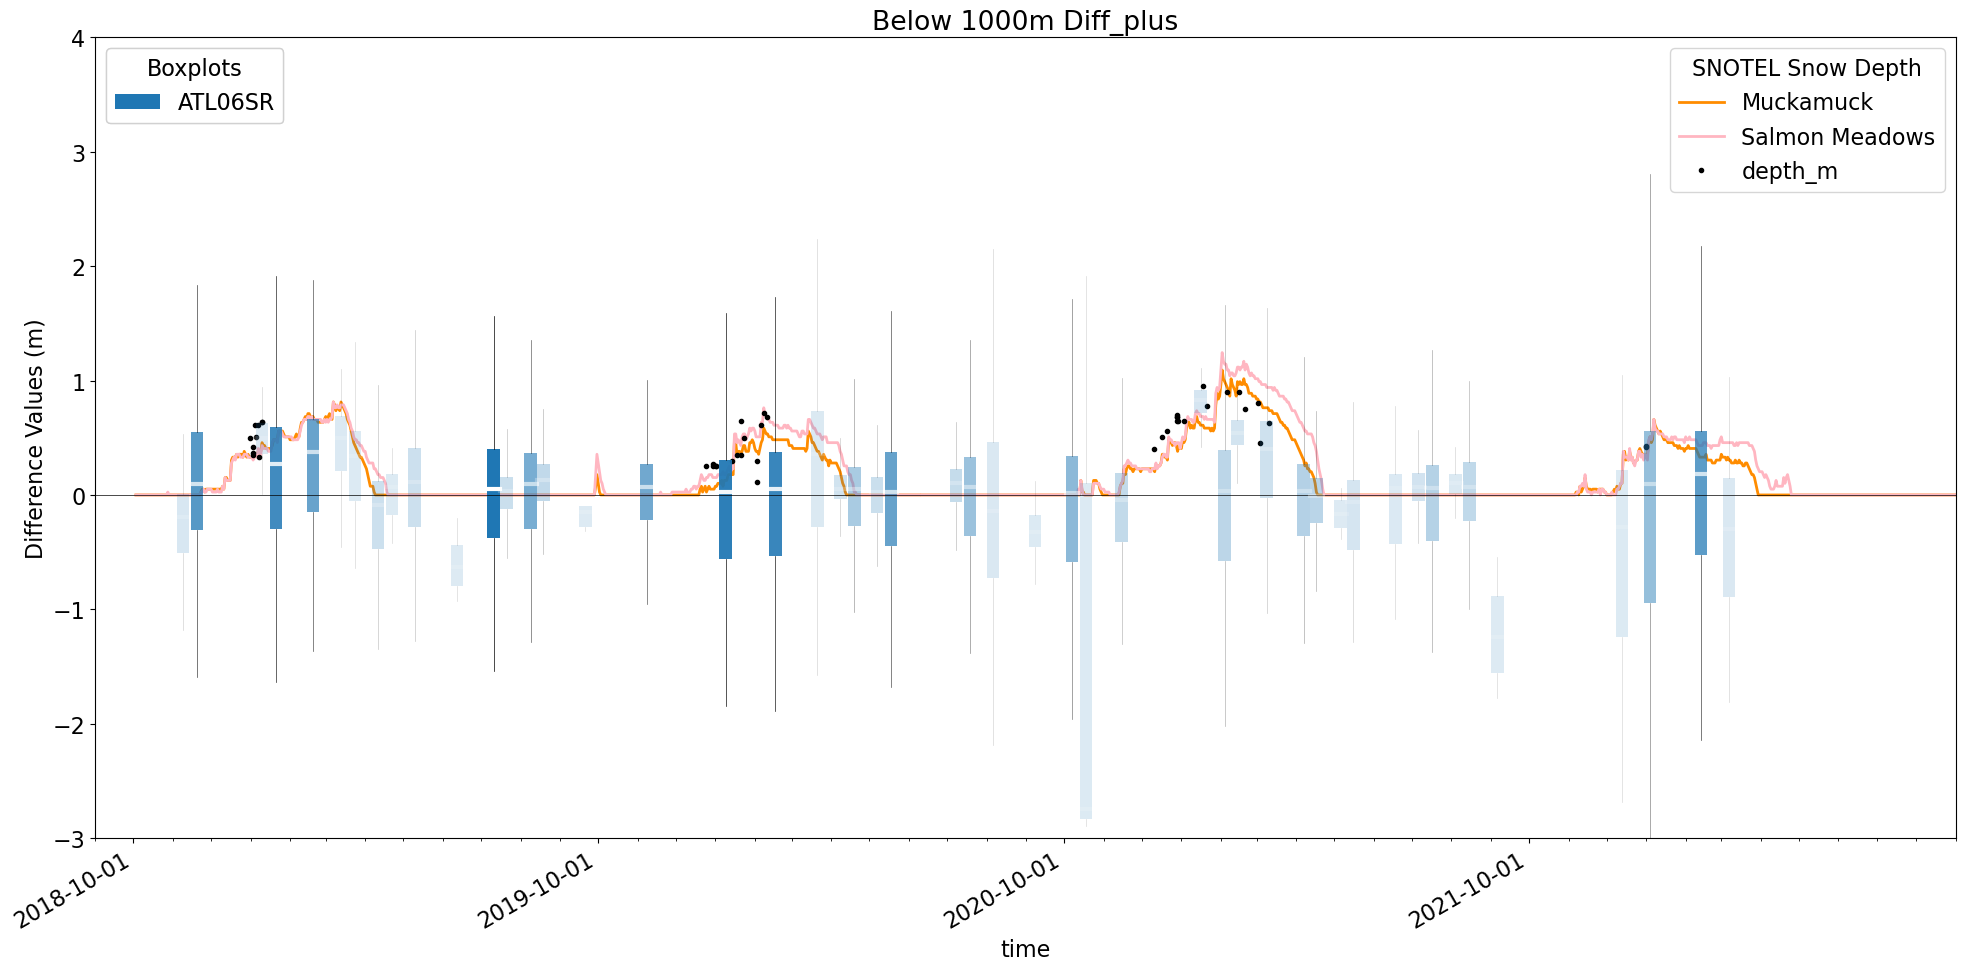

In [303]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['lidar_z']<1000], 'diff_plus', cso_bounds=[0, 1000],  clim=(-3,4), title = 'Below 1000m Diff_plus', name = 'boxplots_diffplus_slope10')
#snotel_list=snotel_sites[snotel_sites['elevation_m']<1000]['name'],

# Separate Diff Plus Low Slope By Elevation

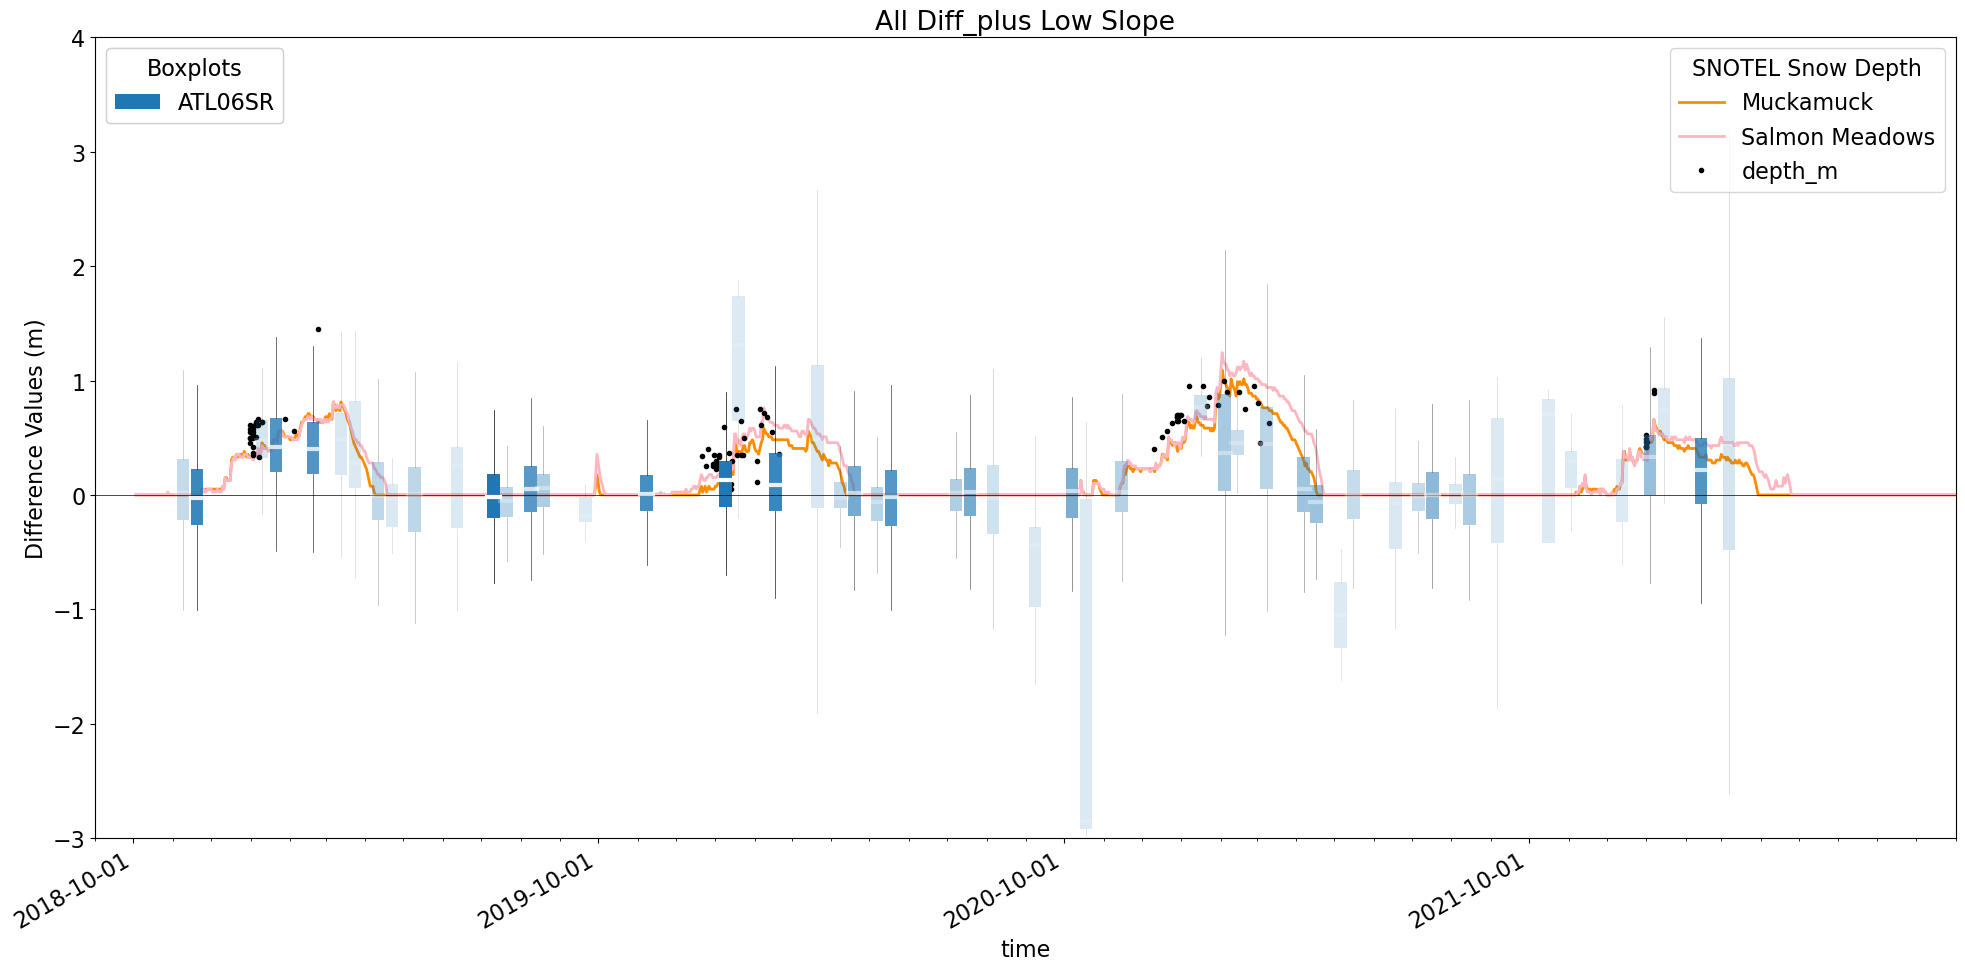

In [304]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus_lowslope', clim=(-3,4), title = 'All Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

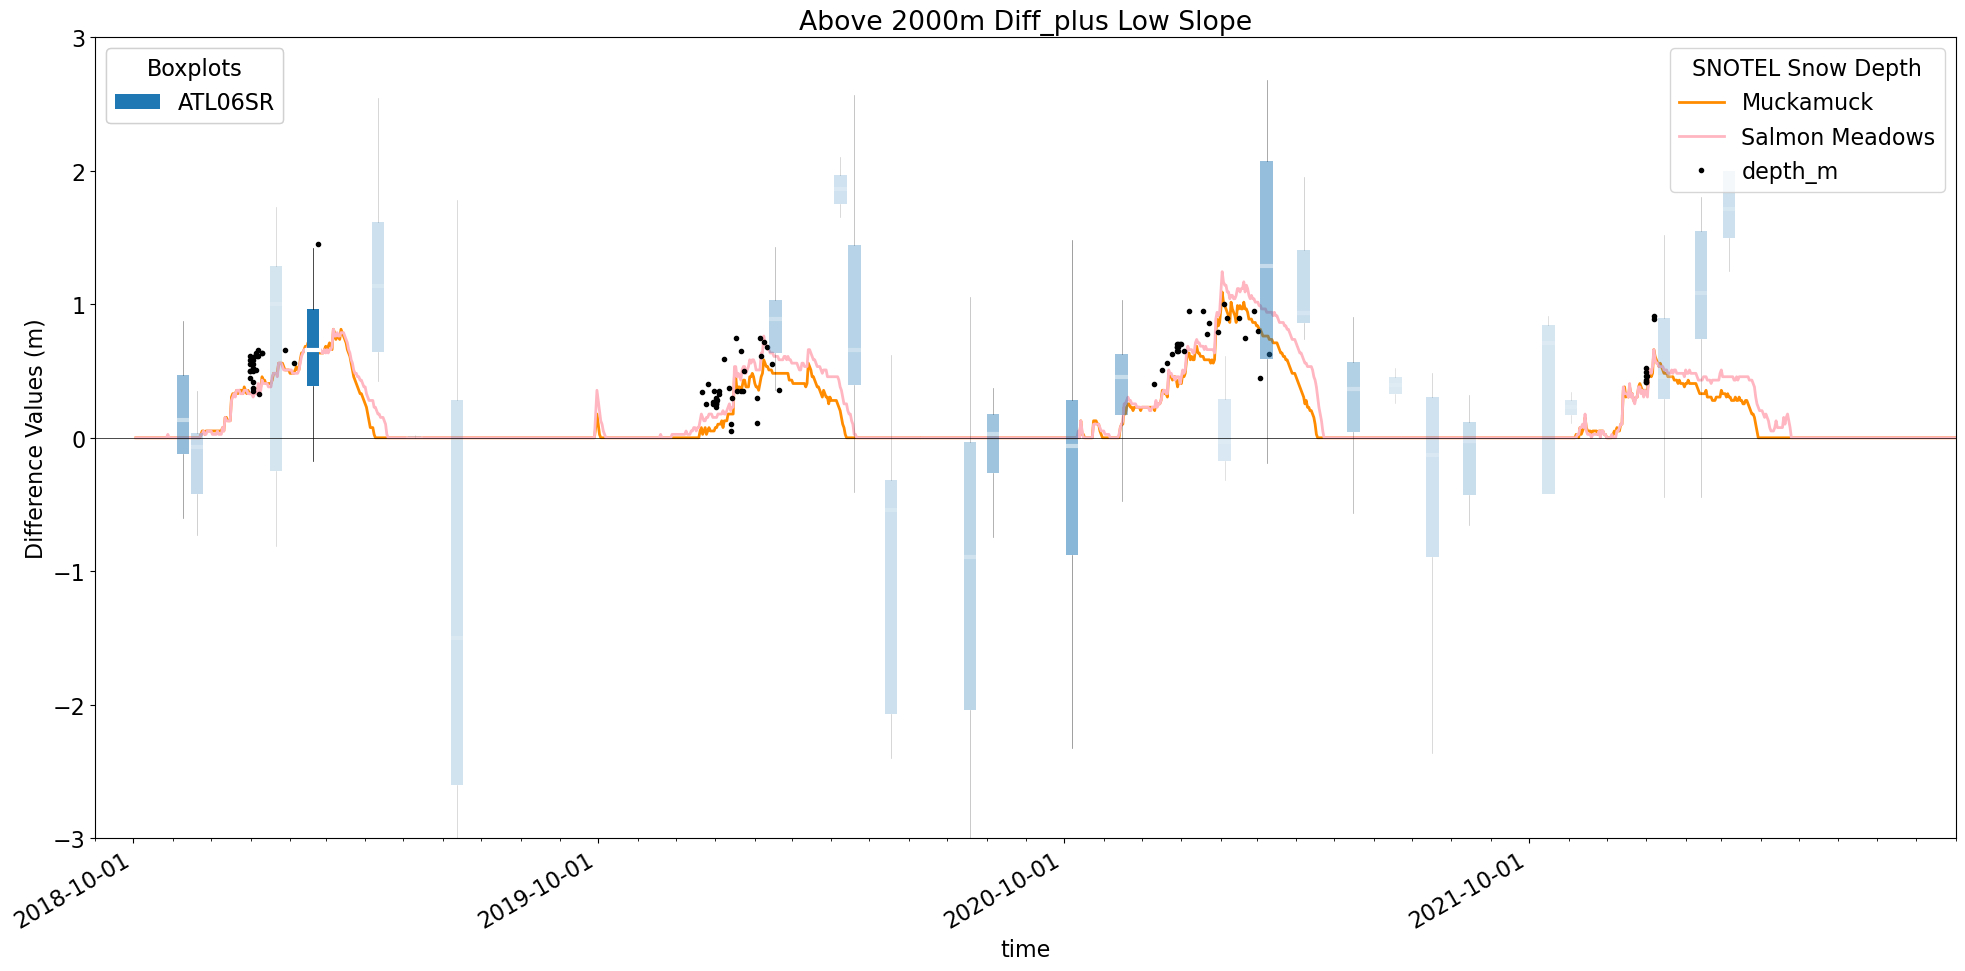

In [308]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']>2000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', clim=(-3,3), title = 'Above 2000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

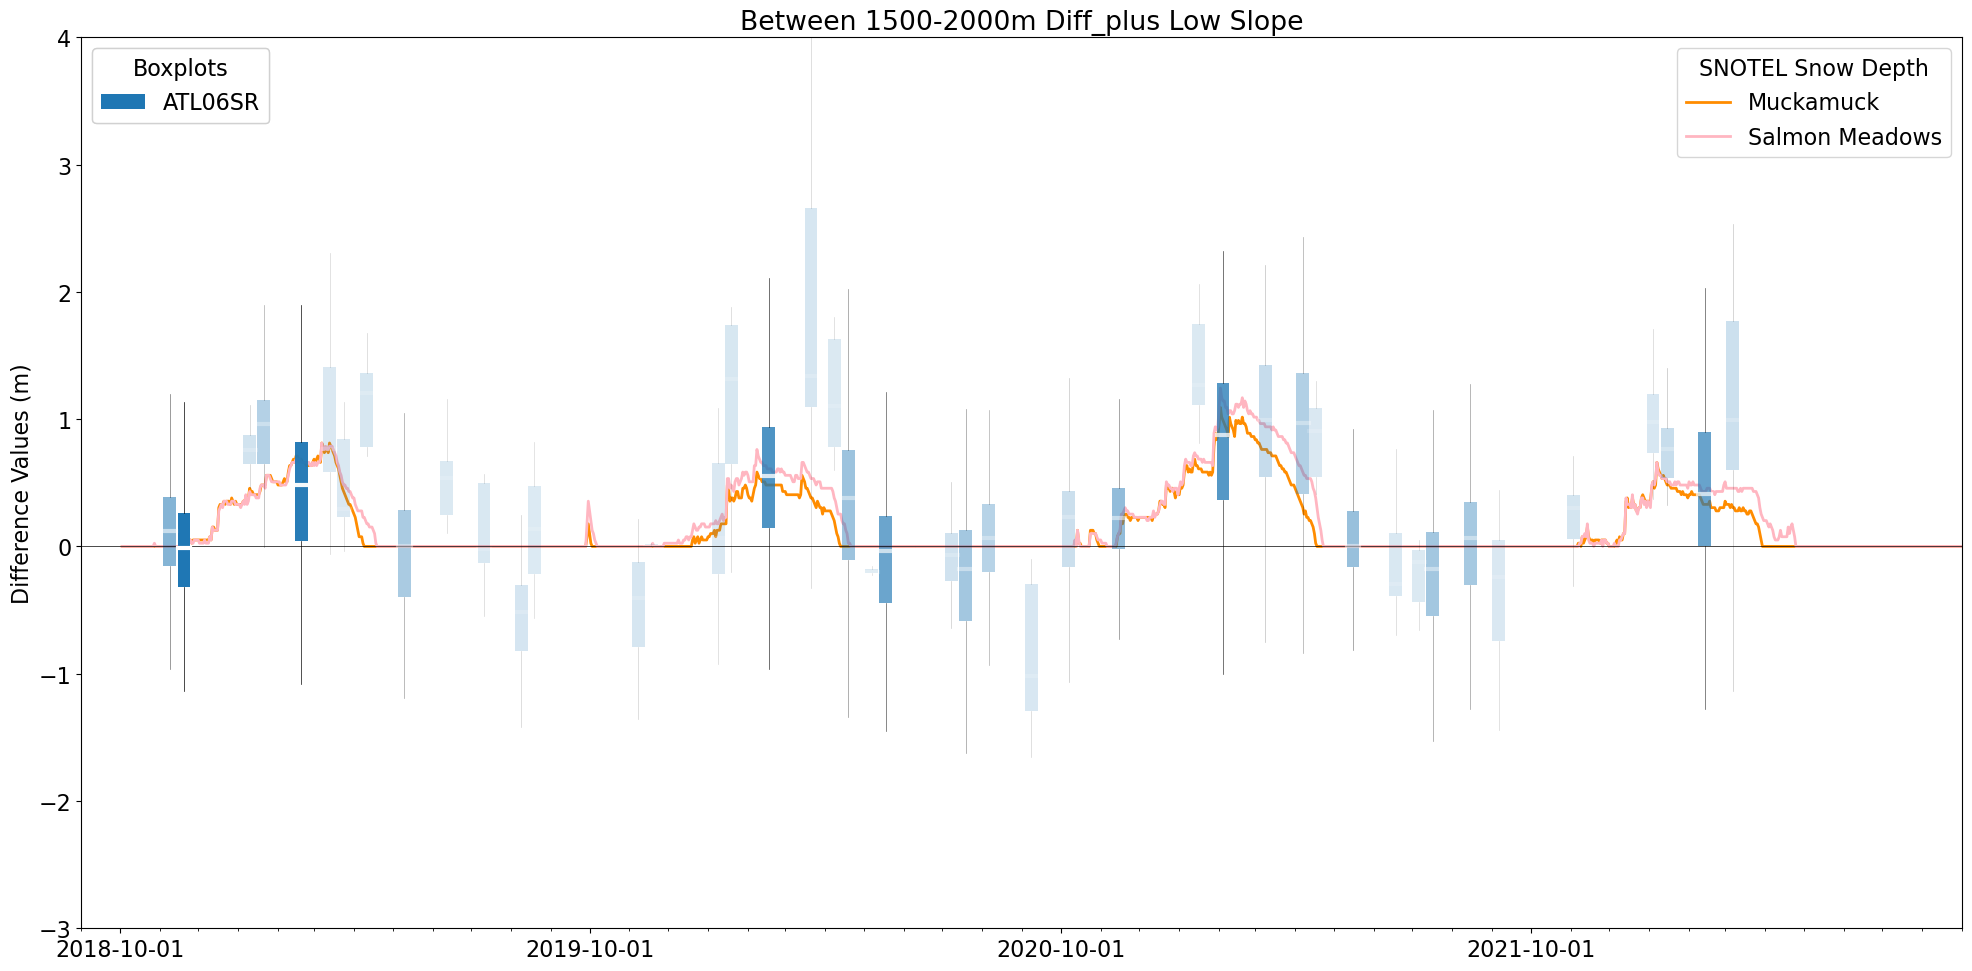

In [223]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<2000) & (atl06sr_gdf['lidar_z']>1500) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', clim=(-3,4), title = 'Between 1500-2000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

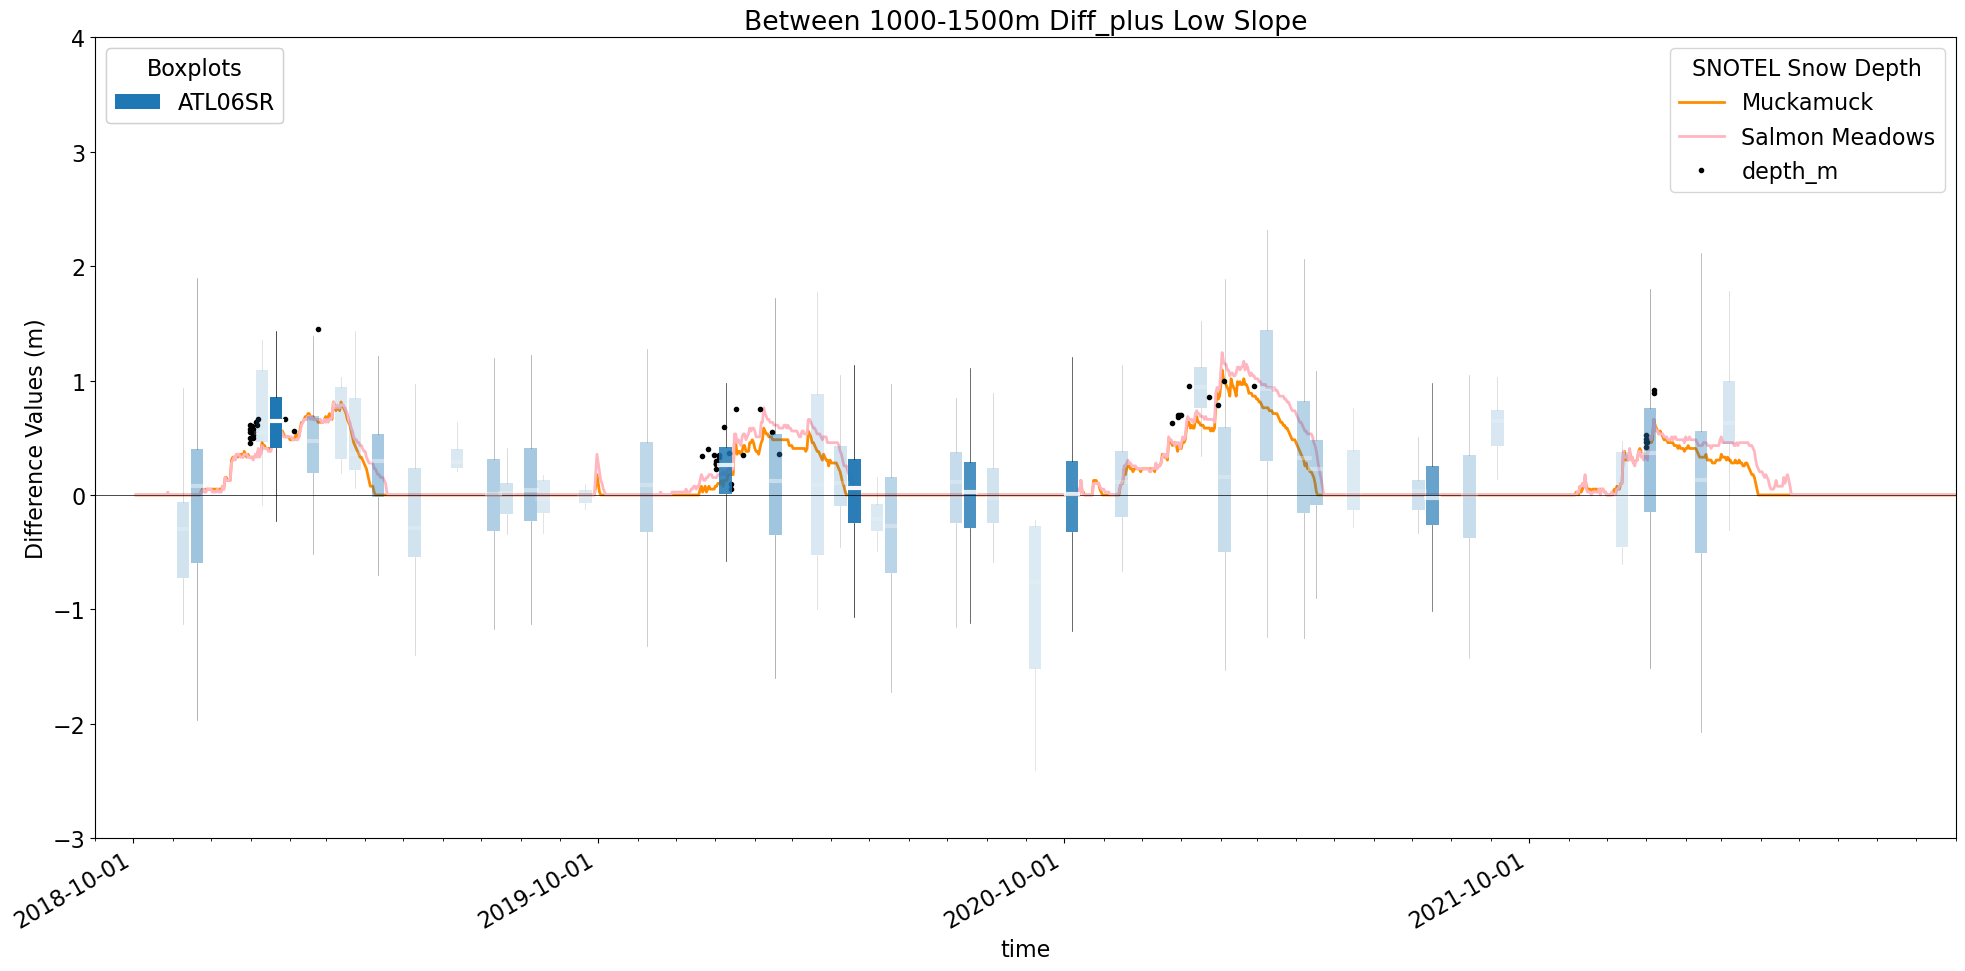

In [305]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1500) & (atl06sr_gdf['lidar_z']>1000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', cso_bounds=[1000, 1500], clim=(-3,4), title = 'Between 1000-1500m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

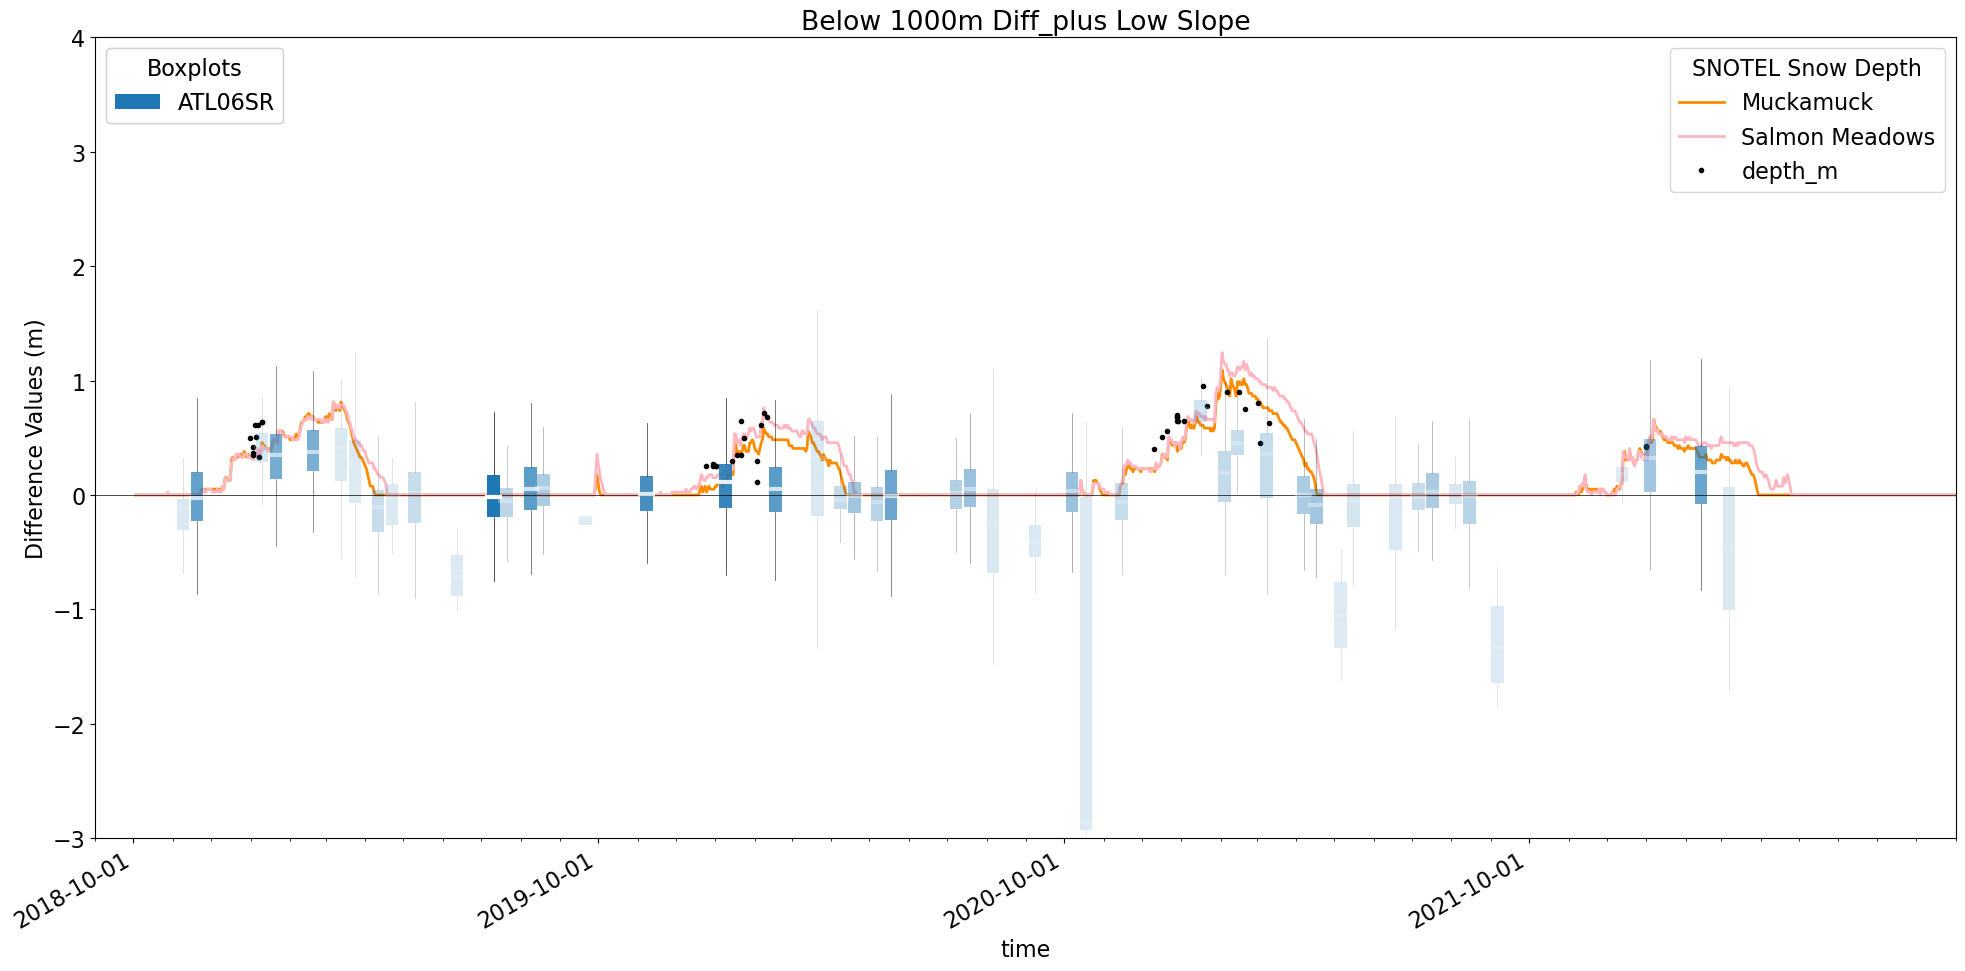

In [306]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[(atl06sr_gdf['lidar_z']<1000) & (atl06sr_gdf['slope_20m']<10)], 'diff_plus_lowslope', cso_bounds=[0, 1000], clim=(-3,4), title = 'Below 1000m Diff_plus Low Slope', name = 'boxplots_diffplus_slope10')

In [183]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


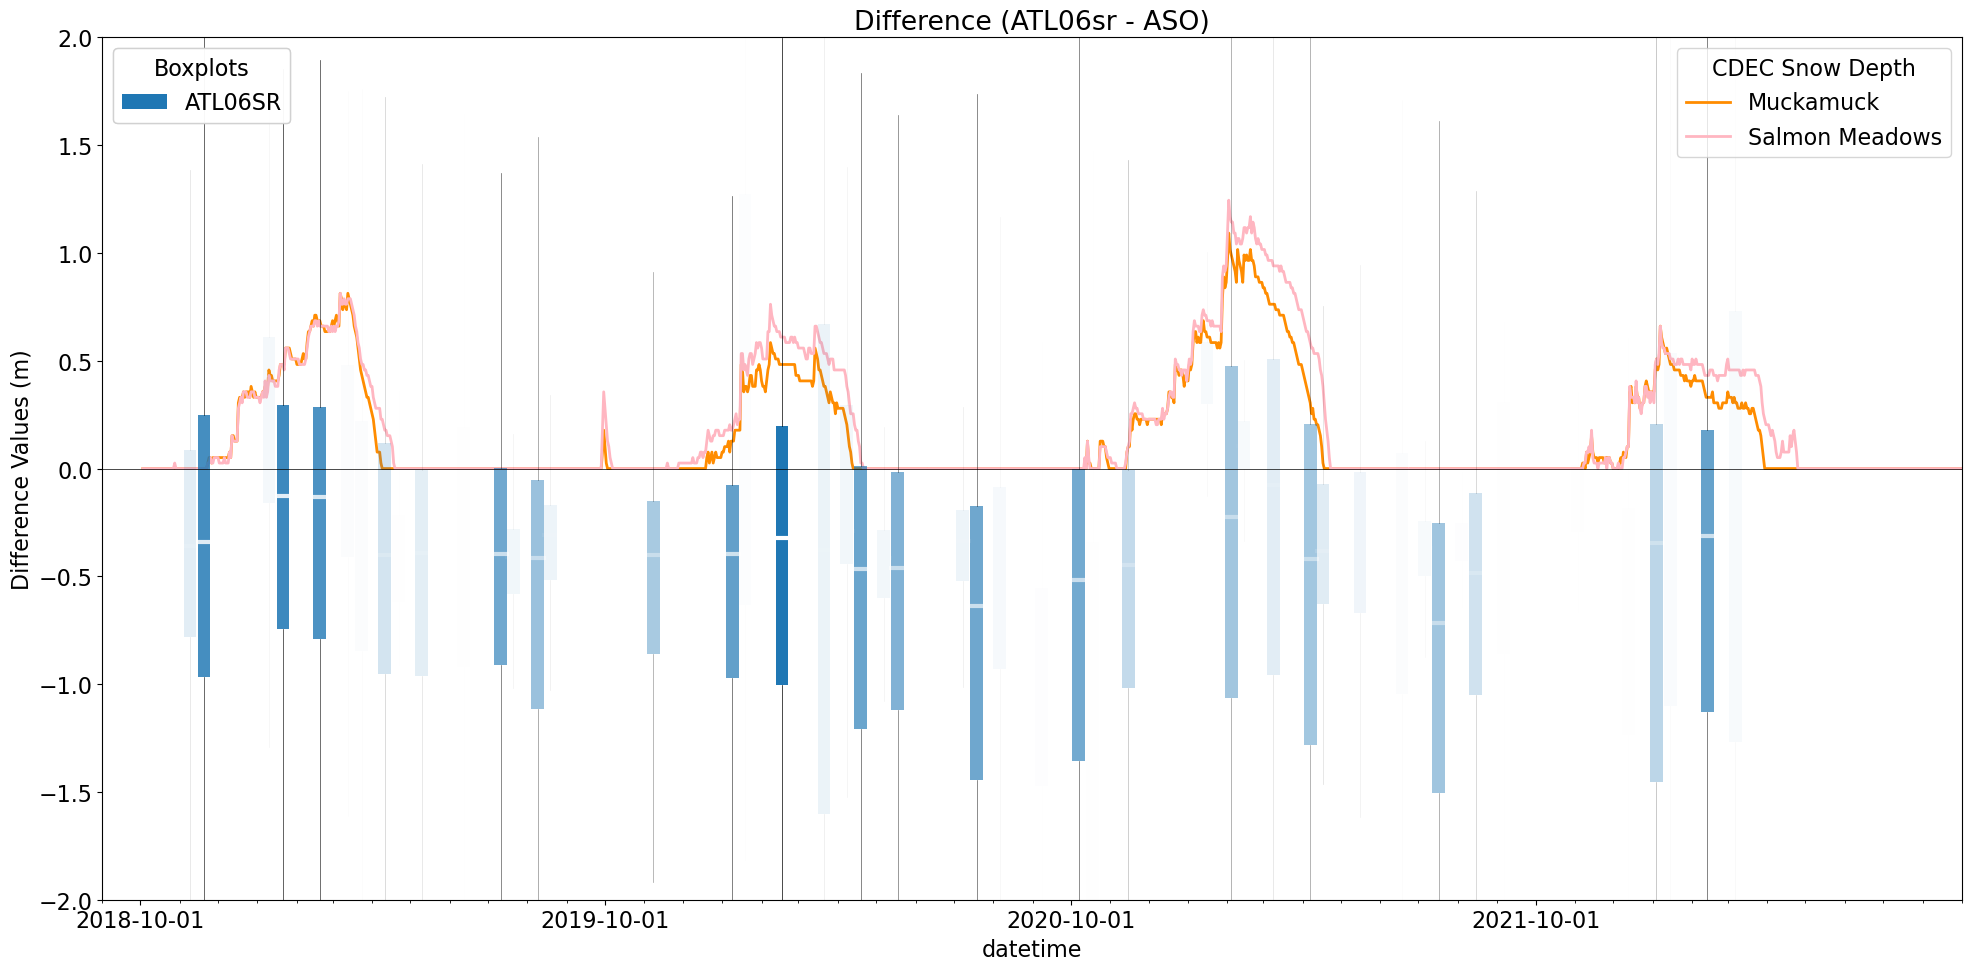

In [29]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,2), title='Difference (ATL06sr - ASO)', name ='boxplots_difference.jpeg')

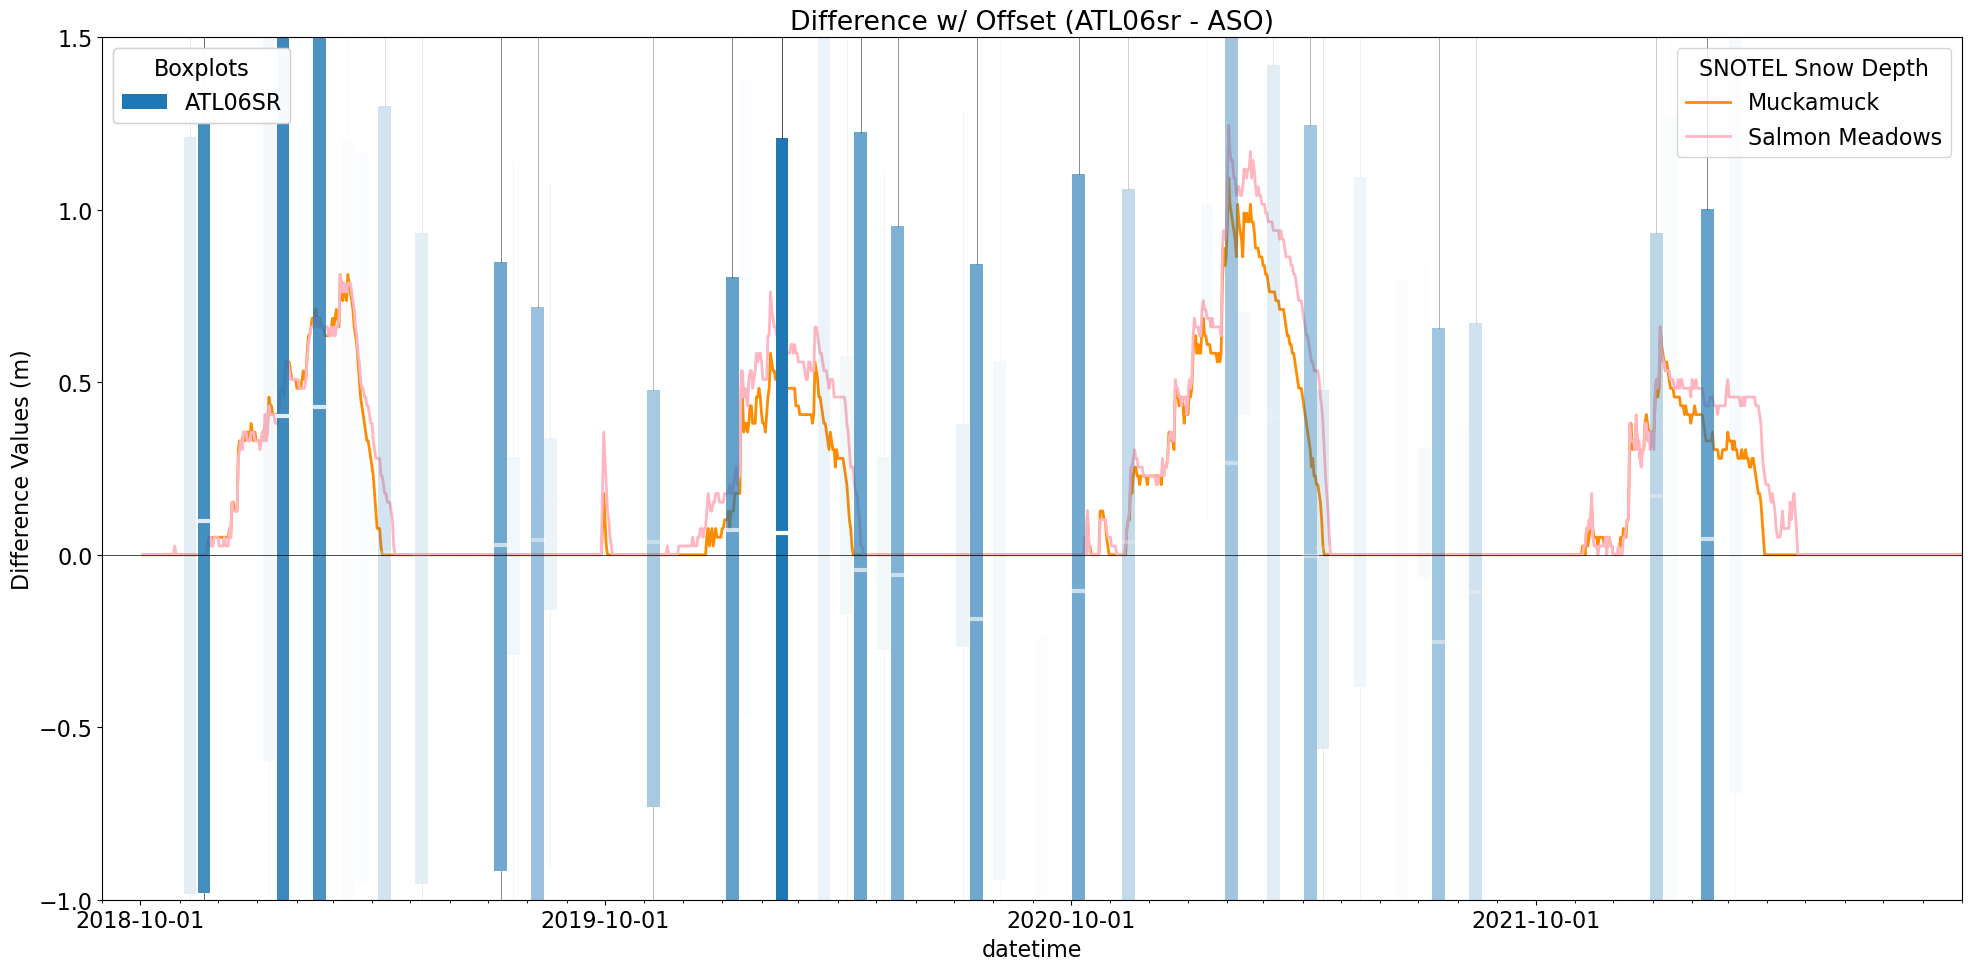

In [40]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-1,1.5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_20m')

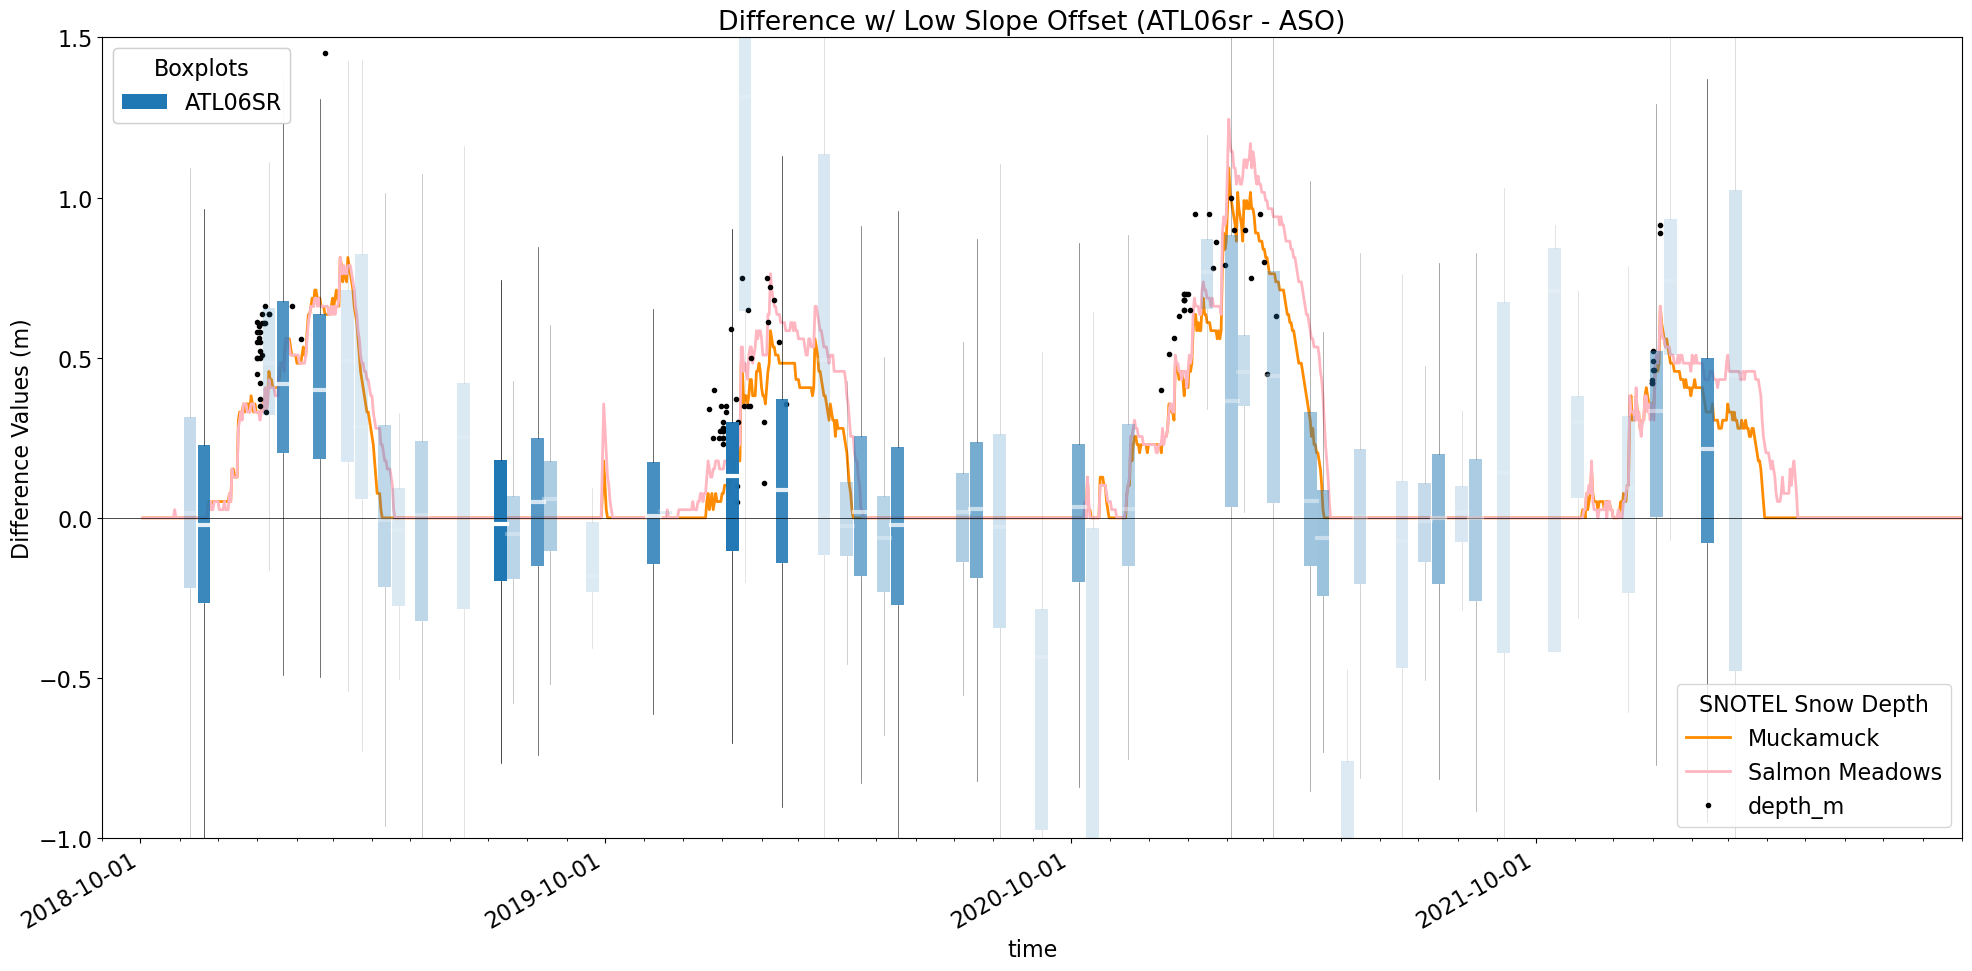

In [310]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus_lowslope', clim=(-1,1.5), title = 'Difference w/ Low Slope Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_lowslope_offset')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

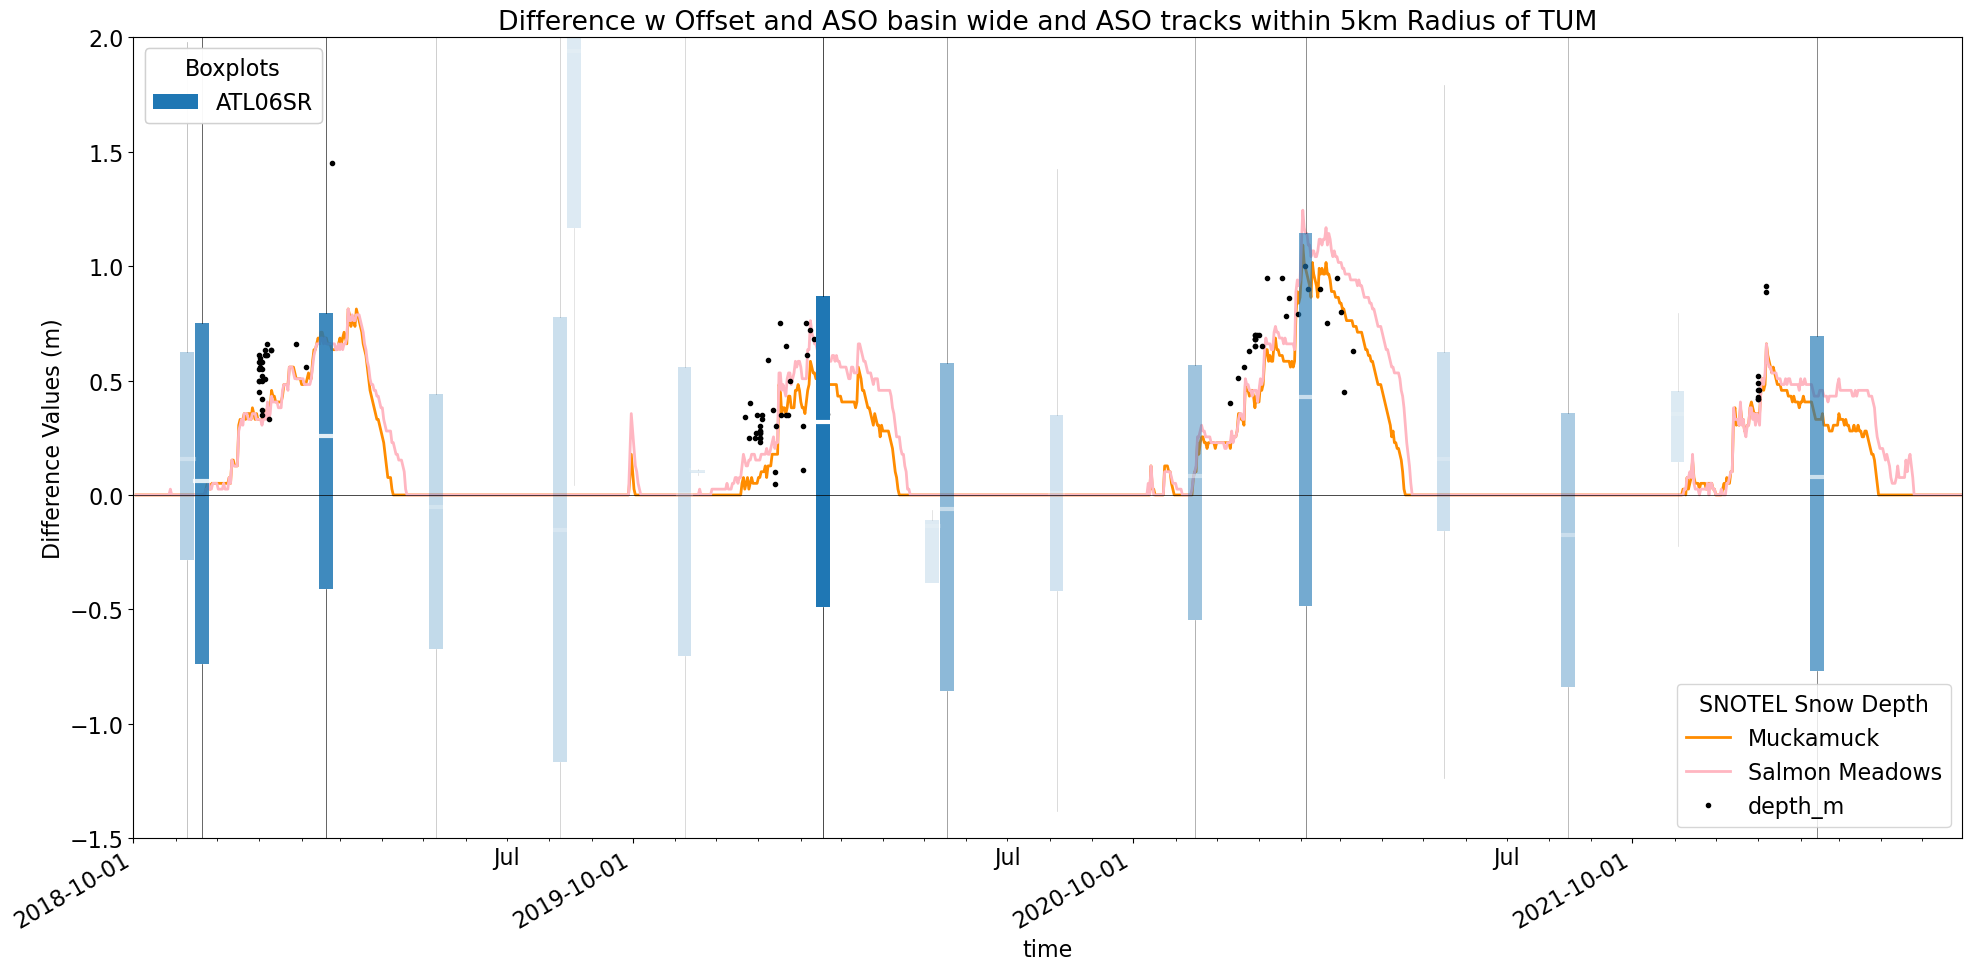

In [349]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(snotel_geom.loc[2, 'geometry'])], col='diff_plus', clim=(-1.5,2), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = 'boxplots_asotracks_basin_tum5.jpeg')

In [ ]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = 'boxplots_asotracks_basin_dan5.jpeg')

# Create Comparison Table

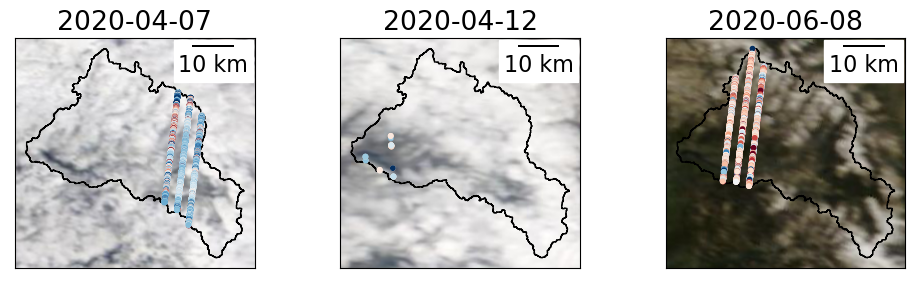

In [203]:
dates_2020 = [datetime.date(2020,4,7), datetime.date(2020,4,12), datetime.date(2020,6,8)]
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, dates_2020):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf[atl06sr_gdf['acqdate'] == date].plot(ax=ax, column='diff_plus', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

## Old, less universal plotting functions:

In [157]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [158]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)